# Random Forest Model Development

This notebook goes through model development for a Random Forest (RF) regressor designed for high-resolution nutrient prediction in the Southern Ocean. The RF model is trained on data from ocean autonomous profilers, called Argo floats and Seagliders, which take measurements of ocean properties as they are carried by the currents. (This is a gross oversimplification, and further detail is provided in Song et al. (2024) [in progress, AIES].)

Here,  go through the major steps of 
(1) Data Processing,
(2) 

The next notebook, '../Analysis_RandomForest.ipnyb' will use this output to analyze the performance.

# Introduction: Random Forest Background

Random Forest (RF) regression is a supervised machine learning method that averages the results over a "forest" of $n$ decision trees for final prediction. Each decision tree determines a series of conditions at each node based on a set of observed variables, referred to as features. For regression, the trees find conditions that best separate the target observations into branches with the least variance. 

Formally, observations are sorted into $j$ regions of predictor space ($R_j$) during training. Following the notation in James et al. (2013), each node in the tree considers a split into two new regions based on a condition $s$ for a predictor $X_j$:
\begin{equation}
\begin{split}
R_1(j,s) = \{X|X_j < s\} \text{ and } R_2(j,s) = \{X|X_j \ge s\}, \\
\end{split}
\end{equation}
and each region is assigned a prediction value that is the average of all target variable values ($\hat{y}_{R_j}$ ) within $R_j$. The condition $s$ is chosen to minimize the residual sum of squares in the resulting bins:
\begin{equation}
\begin{split}
\sum_{i: \: x_i \in \: R_1(j,s)}{} (y_i-\hat{y}_{R_1})^2 \; + \sum_{i: \: x_i \in \: R_2(j,s)}{} (y_i-\hat{y}_{R_2})^2,
\end{split}
\end{equation}
where $y_i$ represents each observed value. During testing, validation, and prediction, RF sorts input observations into the regions and assigns them the value $\hat{y}_{R_j}$. One advantage of RF is that it limits the decision at each node split to a random subset of features. As a result, the trees in Random Forest are less correlated than those in a family of ``bagged'' trees which consider all possible features at all nodes. The RF method is therefore less prone to overfitting, especially on spatiotemporally biased data (Stock et.al (2022), Sharp et al. 2022). 

# PART 0: Import Packages and Plotting Parameters

In [14]:
# Data Structure/Organization Packages
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma

# Machine Learning/Statistics Packages
import scipy
from scipy.stats import kde
from scipy.stats import iqr
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

# Plotting Packages
import matplotlib.pyplot as plt
from cmocean import cm as cmo
import seaborn as sns
import matplotlib.patches as patch
from labellines import labelLine, labelLines
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patheffects as pe

# Utility Packages
import random as rand
import os
import math
import itertools
from scipy import interpolate
from tqdm import tqdm

# Oceanography Packages
import gsw
import sgmod_main as sg
import sgmod_L3proc as gproc     # for L3 grid processing
import sgmod_DFproc as dfproc    # for dataframe processing
import sgmod_plotting as sgplot  
import importlib
import geopy.distance


In [2]:
# Input glider data, which has already been quality controlled. 
sg659 = pd.read_csv('../data/glider/mldata_sg659_tsO2corr.csv')
sg660 = pd.read_csv('../data/glider/mldata_sg660_tsO2corr.csv')

# Dive-averaged glider data
df_659 = pd.read_csv('../data/glider/mldata_sg659_tsO2corr.csv')
df_660 = pd.read_csv('../data/glider/mldata_sg660_tsO2corr.csv')
dav_659 = pd.read_csv('../data/glider/sg659_diveavg.csv')  
dav_660 = pd.read_csv('../data/glider/sg660_diveavg.csv')

# Float data: 
floatDF = pd.read_csv('../data/floats/mldata_floatDF_qc.csv')
sgfloat = floatDF[(floatDF.yearday<205) & (floatDF.wmoid==5906030)]
dav_float = pd.read_csv('../data/floats/sgfloat_diveavg.csv')

# Ouput of this notebook: 
# df_659 = pd.read_csv('RFpred_659_modG_split2023.csv')
# df_660 = pd.read_csv('RFpred_660_modG_split2023.csv')

### Plotting Parameters

In [3]:
size = 16
plt.style.use('default')
params = {'legend.fontsize': size, 
          'xtick.labelsize':size, 
          'ytick.labelsize':size, 
          'font.size':size,
          'font.family':'Futura'}
plt.rcParams.update(params)


# Set glider plotting
plat_colors = dict({'sg659':'#33BBEE', 'sg660':'#EE3377', 'float':'#CCBB44'})


# PART 1: Training Data: Ocean Autonomous Profilers

## 1.0 Study Region

Here, we develop a regional model using SOGOS observations, GO-SHIP I06 bottle data and observations from six BGC-Argo floats (WMO: 5904469, 5904659, 5905368, 5905996, 5906031, 5906207), which provided coverage of the Antarctic Southern Zone (ASZ) bounded by the Polar Front and Sea Ice Edge.  

The Seagliders sampled for 86 days, from May 1, 2019 to July 25, 2019, covering a region spanning approximately 30-40 E and 50-54 S as shown below. SG659 and SG660 completed 456 and 502 V-shaped dives, respectively, to approximately ~1000 m and sampled during both the descent and ascent. The gliders generally surfaced every 4-6 hours (profiles every 2-3 hours), while the BGC-Argo float sampled with a 5-day profiling frequency. The SOGOS float returned 16 profiles within the duration of the Seaglider mission. After being deployed along the 30E I06 cruise track around -51.5S, the three profilers were advected eastward by the Antarctic Circumpolar Current (ACC). The platforms pass through a standing meander region by the Southwest Indian Ridge (SWIR), which is a known hotspot of enhanced eddy kinetic energy (EKE) (balwada2024_Tracer, yung2022_Topographic). Further details on the deployment and the profilers' path from a high to low EKE region can be found in Dove et. al. (2021). 


In [15]:
# Use AVISO satellite data to see study bounds. 
aviso = xr.open_dataset('../data/satellite/dataset-duacs-nrt-global-merged-allsat-phy-l4_1637011653931.nc')
aviso['eke'] = np.sqrt(aviso.ugosa**2 + aviso.vgosa**2)

# Download fronts of the Antarctic Circumpolar Current
PF = pd.read_csv('../data/ACC_fronts/PF.csv', header=None)
SIF = pd.read_csv('../data/ACC_fronts/SIF.csv', header=None)
for csv in [PF, SIF]:
    csv.columns = ['lon', 'lat']

### Figure: Study Region

(a) Trajectories for Seagliders SG659 and SG660 are shown in blue and magenta, respectively. 
Yellow diamonds denote locations of the float profiles. 

(b) Expanded view of the float (yellow) and glider SG660 (magenta) as they traverse from the high EKE region (yeardays<150) to the low EKE region (yeardays<170). 
Magenta text indicates yearday of the subset of observations highlighted in purple. Background colored by EKE [m^2/s^2] averaged over the deployment period.

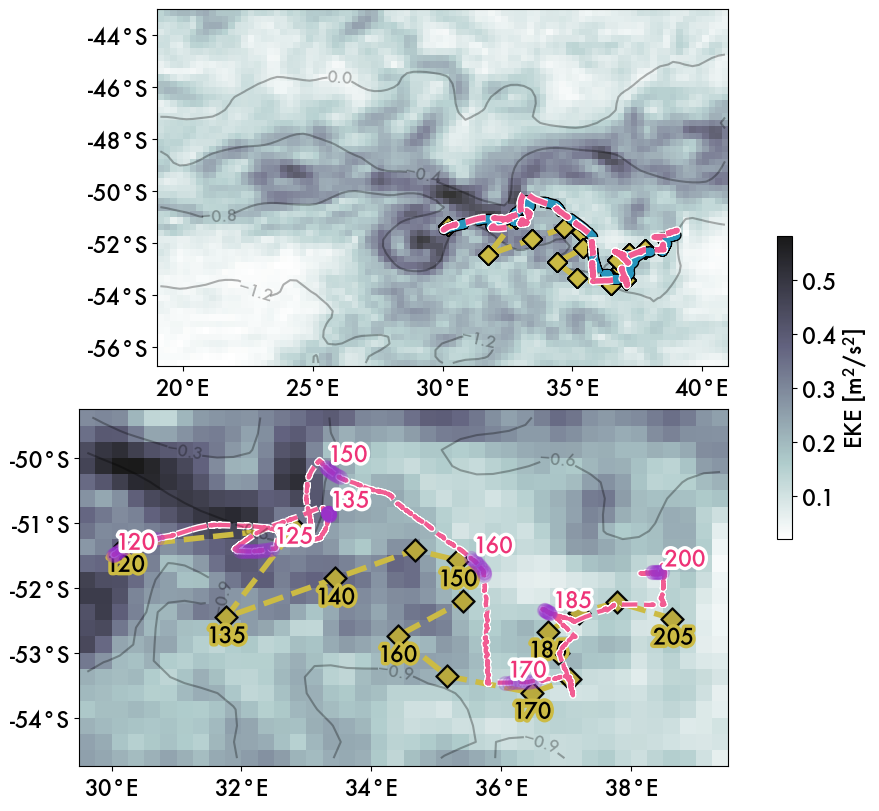

In [16]:
# Map of study region, colored by Eddy Kinetic Energy (EKE)
# Red areas indicate turbulence
# Grey contours are the Absolute Dynamic Topography (ADT)
# Glider tracks SG659 in teal, SG660 in magenta
fig, axs = plt.subplots(2,1, figsize=(11,8), layout='constrained')
axs = axs.flatten()

# Plot larger study region
for ax in [axs[0]]:
        datestart='2019-04-30'
        dateend='2019-07-25'
        lat1=-56.8; lat2=-43
        lon1=19; lon2=41
        data_sat = aviso.sel(time=slice(datestart, dateend))
        data_sat = data_sat.sel(latitude=slice(lat1, lat2))
        data_sat = data_sat.sel(longitude=slice(lon1, lon2))
        avg_aviso = data_sat.mean(dim='time')

        # Plot background EKE (separately because of region area)
        sca = avg_aviso.eke.plot(ax=ax, cmap='bone_r', alpha=0.8, add_colorbar=False, vmin=0.02, vmax=0.58)
        # fig.colorbar(sca, ax=ax, shrink=0.5).set_label('EKE')
        contour = ax.contour(avg_aviso['longitude'], avg_aviso['latitude'], avg_aviso['adt'], 
                                colors='k', alpha=0.3, linestyles='solid', zorder=1, levels=4)
        ax.clabel(contour, inline=True, fontsize=12)  # Add labels to contour lines

        # Plot float
        ax.plot(sgfloat.lon,sgfloat.lat, color =  '#CCBB44', alpha=1, linewidth=4, linestyle='dashed',
                label='float', zorder=3)  # sns.color_palette("Oranges")[3]
        ax.scatter(sgfloat.lon,sgfloat.lat, color =  '#CCBB44', alpha=0.9, s=90, 
                marker='D', edgecolors='k', zorder=3)

        # Gliders
        ax.plot(sg659.lon, sg659.lat, color = plat_colors['sg659'], alpha=0.8, linewidth=6, linestyle='dashed', label='sg659', 
                path_effects=[pe.Stroke(linewidth=8, foreground='k'), pe.Normal()], zorder=3) 

        ax.plot(sg660.lon, sg660.lat, color = plat_colors['sg660'], alpha=0.8, linewidth=4, linestyle='dashed', label='sg660', 
                path_effects=[pe.Stroke(linewidth=6, foreground='w'), pe.Normal()], zorder=3) 

# Plot inset, zoomed into study area with yeardays labeled.
for ax in [axs[1]]:
        datestart='2019-04-30'
        dateend='2019-07-25'
        lat1=-54.7; lat2=-49.2
        lon1=29.5; lon2=39.4
        data_sat = aviso.sel(time=slice(datestart, dateend))
        data_sat = data_sat.sel(latitude=slice(lat1, lat2))
        data_sat = data_sat.sel(longitude=slice(lon1, lon2))
        avg_aviso = data_sat.mean(dim='time')

        # Plot float
        ax.plot(dav_float.lon,dav_float.lat, color =  '#CCBB44', alpha=1, linewidth=4, linestyle='dashed',
        label='float', zorder=3)  # sns.color_palette("Oranges")[3]
        ax.scatter(dav_float.lon.values,dav_float.lat.values, color =  'k', alpha=0.9, s=140, 
                marker='D', edgecolors='k', zorder=3)
        ax.scatter(dav_float.lon.values,dav_float.lat.values, color =  '#CCBB44', alpha=0.9, s=110, 
                marker='D', edgecolors='k', zorder=3)
        
        for ind, day in enumerate([int(x) for x in dav_float.yearday.values]):
                if day in ([120,135,140,150, 160, 170, 185, 205]):
                        ax.text(dav_float.lon.loc[ind]-.3, dav_float.lat.loc[ind]-.4, str(day), 
                                        fontsize=16, color='k',
                        path_effects=[pe.Stroke(linewidth=5, foreground='#CCBB44'), pe.Normal()], zorder=3)

        # Plot Glider
        ax.plot(sg660.lon, sg660.lat, color = plat_colors['sg660'], alpha=0.8, linewidth=3, linestyle='dashed', label='sg660',
                path_effects=[pe.Stroke(linewidth=5, foreground='w'), pe.Normal()], zorder=3) 

        # Plot every 10th glider position
        for day in [120,125,135, 150, 160, 170, 185, 200]:
                i = np.where(dav_660.yearday.round()==day)
                ax.scatter(dav_660.lon.loc[i].values, dav_660.lat.loc[i].values, s=100, color='darkorchid', alpha=0.2, zorder=3)
                ax.text(dav_660.lon.loc[i].values[0]+.04, dav_660.lat.loc[i].values[0]+0.08, str(day), 
                                fontsize=16, color=plat_colors['sg660'],
                        path_effects=[pe.Stroke(linewidth=5, foreground='w'), pe.Normal()], zorder=3)


        # Plot EKE
        sca = avg_aviso.eke.plot(ax=ax, cmap='bone_r', alpha=0.9, add_colorbar=False, zorder=0, vmin=0.02, vmax=0.58)
                        # cbar_kwargs={'label': 'EKE ' + r'$\mathregular{[m^2/s^2]}$'})
        # fig.colorbar(sca, ax=ax).set_label('EKE ' + r'$\mathregular{[m^2/s^2]}$')


        # Plot ADT Contours
        contour = ax.contour(avg_aviso['longitude'], avg_aviso['latitude'], avg_aviso['adt'], 
                        colors='k', alpha=0.3, linestyles='solid', zorder=1, levels=2)
        ax.clabel(contour, inline=True, fontsize=12)  # Add labels to contour lines

fig.colorbar(sca, ax=axs[:], shrink=0.4).set_label('EKE ' + r'$\mathregular{[m^2/s^2]}$')

for ax in axs:
    ax.yaxis.set_major_formatter("{x:1.0f}°S")
    ax.xaxis.set_major_formatter("{x:1.0f}°E")
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_aspect('equal')


## 1.1 Identify Training Floats

Observations are first separated into training, validation, and test datasets during development. Our regional model is developed using GO-SHIP I06 bottle data and observations from six BGC-Argo floats (WMO: 5904469, 5904659, 5905368, 5905996, 5906031, 5906207; Figure \ref{fig:argo_map}), which provided coverage of the Antarctic Southern Zone (ASZ) bounded by the Polar Front and Sea Ice Edge. The combined GO-SHIP and BGC-Argo dataset is split 80\% and 20\% into the training and validation datasets, respectively (Figure \ref{fig:workflow}, \ref{fig:argo_map}). Typical machine learning workflows normally construct test datasets by random subsampling. However, our goal for testing in this particular use case is to get a final independent estimate of model error when applied onto the Seaglider tracks. Since the Seagliders sample close to the SOGOS float by experimental design, the entirety of the SOGOS float data (WMO 5906030) is reserved for testing. We emphasize that RF applications in the geosciences should consider the specific goal of the regressor when determining what data constitutes the training and test datasets. 

In [17]:
# Import ship and float data for training
floatDF = pd.read_csv('../data/floats/mldata_floatDF_qc.csv')
shipDF = pd.read_csv('../data/go-ship/mldata_shipDF_qc.csv')
shipDF = shipDF.reset_index(drop = True)

# Set up WMO color palette
wmoids = pd.unique(floatDF.wmoid)
wmo_colors = dict.fromkeys(wmoids)

wmo_colors[5904469]=sns.color_palette("RdPu")[4]
wmo_colors[5904659]=sns.color_palette("Purples")[4]
wmo_colors[5905368]=sns.color_palette("Paired")[1]
wmo_colors[5905996]=sns.color_palette("YlGn")[3]
wmo_colors[5906030]='k' # sns.color_palette("Reds")[3]  # SOGOS 
wmo_colors[5906030]='k' 
wmo_colors[5906031]=sns.color_palette("Blues")[2]
wmo_colors[5906207]=sns.color_palette("Reds")[4]
wmo_colors[5906007]= sns.color_palette("YlOrRd")[3]

In [18]:
# Methods
def print_bounds(DF):
    # print('Bounds of data: \n')
    print('Dates: \t\t' + str(sg.ytd2datetime(DF.yearday.min())) + ' to ' + str(sg.ytd2datetime(DF.yearday.max())))
    print('Latitude:\t' + str(DF.lat.min()) + ' to ' + str(DF.lat.max()))
    print('Longitude:\t' + str(DF.lon.min()) + ' to ' + str(DF.lon.max()))
    
def restrict_DF(data, start_yd, end_yd, lat1, lat2, lon1, lon2):
    data = data[(data.lat > lat1) & (data.lat < lat2)]
    data = data[(data.lon > lon1 ) & (data.lon <lon2)]
    data = data[(data.yearday > start_yd) & (data.yearday < end_yd)]
    return data

In [19]:
# Restrict the data to Antarctic Southern Zone (ASZ) region
argo_qc = dfproc.between_fronts(floatDF, PF, SIF, buffers=[0.5,0.5])
ship_qc = dfproc.between_fronts(shipDF, PF, SIF, buffers=[0.5,0.5])

# Restrict by time
start_yd = sg.datetime2ytd(np.datetime64('2017-04-20')) # datetime(2019,4,30)  # yd 120
end_yd = sg.datetime2ytd(np.datetime64('2021-07-30')) # datetime(2019,7,19)  # yd 200

# Remove some points that appear to roam outsize the ASZ
lat1 = -65; lat2 = -45
lon1 = 5; lon2 = 65
argo_qc = restrict_DF(argo_qc, start_yd, end_yd, lat1, lat2, lon1, lon2)
ship_qc = restrict_DF(ship_qc, start_yd, end_yd, lat1, lat2, lon1, lon2)

print_bounds(argo_qc)
wmoids = argo_qc.wmoid.unique()
print('Number of floats within bounds: ' + str(len(argo_qc.wmoid.unique())))
argo_qc.value_counts('wmoid')

Dates: 		2017-05-08 to 2021-07-11
Latitude:	-58.682 to -49.263
Longitude:	5.3 to 64.896
Number of floats within bounds: 7


wmoid
5905996    3486
5906030    3308
5906031    3256
5904659    2544
5906207    2521
5905368    1488
5904469    1041
dtype: int64

In [20]:
# Remove any floats that have fewer than 100 obs
newdf = pd.DataFrame()
for wmo in wmoids: 
    flo = argo_qc[argo_qc.wmoid==wmo]
    if len(flo)>100:
        newdf = pd.concat([newdf, flo])
    else:
        print('wmo ' + str(wmo) + ' removed.')
argo_qc = newdf.copy()

wmoids = argo_qc.wmoid.unique()
print('Number of floats within bounds: ' + str(len(argo_qc.wmoid.unique())))
# argo_qc.value_counts('wmoid')
print(argo_qc.wmoid.unique())

Number of floats within bounds: 7
[5904469 5904659 5905368 5905996 5906030 5906031 5906207]


/opt/homebrew/Caskroom/mambaforge/base/envs/mlsogos/lib/python3.8/site-packages/labellines/core.py:204: UserWarning: The value at position 2 in `xvals` is outside the range of its associated line (xmin=56.593, xmax=64.538, xval=24.54256183219492). Clipping it into the allowed range.
  warnings.warn(


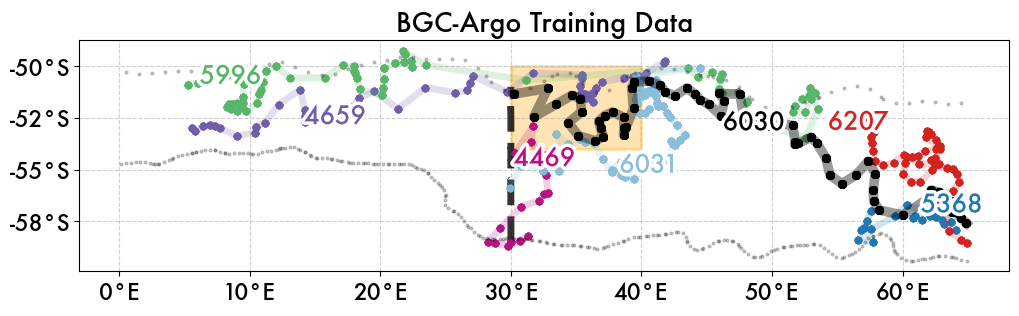

In [21]:
# Reference: Full matchup map for floats

fig = plt.figure(figsize=(12,3))
ax=plt.gca()

for wmo in wmoids[wmoids!=5906030]:
    ax.plot(floatDF[floatDF.wmoid==wmo].lon,floatDF[floatDF.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.2, linewidth=5, label=str(wmo)[3:], zorder=3)
    ax.scatter(floatDF[floatDF.wmoid==wmo].lon,floatDF[floatDF.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.1, s=20, zorder=3)

for wmo in [5906030]:
    ax.plot(floatDF[floatDF.wmoid==wmo].lon,floatDF[floatDF.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.4, linewidth=7, label=str(wmo)[3:], zorder=3)
    ax.scatter(floatDF[floatDF.wmoid==wmo].lon,floatDF[floatDF.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.1, s=30, zorder=3)

for front in [SIF, PF]:
     front = front[(front.lon > 0 ) & (front.lon <65)]
     ax.scatter(front.lon, front.lat, color='k', alpha=0.2, s=4, zorder=3)
#      ax.plot(front.lon, front.lat, color='k', alpha=0.1, linewidth=2, zorder=3)

plt.title('BGC-Argo Training Data')
# plt.title('Argo Yeardays: ' + str(start_yd) + ' to ' + str(end_yd))
rect = patch.Rectangle((30,-54),10,4, fill=True, color="orange", alpha=0.3,linewidth=2, zorder=1)

# ax.legend()
ax.add_patch(rect)
# ax.set_xlim(5,81)
# ax.set_ylim(-60,-30)
# ax.set_aspect('equal')

ax.yaxis.set_major_formatter("{x:1.0f}°S")
ax.xaxis.set_major_formatter("{x:1.0f}°E")

ax.grid(linestyle='dashed', alpha=0.6, zorder=1)

lines = ax.get_lines()
labelLines(lines, align=False, fontsize=18, zorder=3)
# labelLines(lins) # , align=False, fontsize=18)
plt.plot(shipDF.lon, shipDF.lat, alpha=0.8, linestyle='dashed', c='k', linewidth=5)


### 1.1.1 Checking Training Data Distributions

- We do quick screening to make sure the training data are representative. 

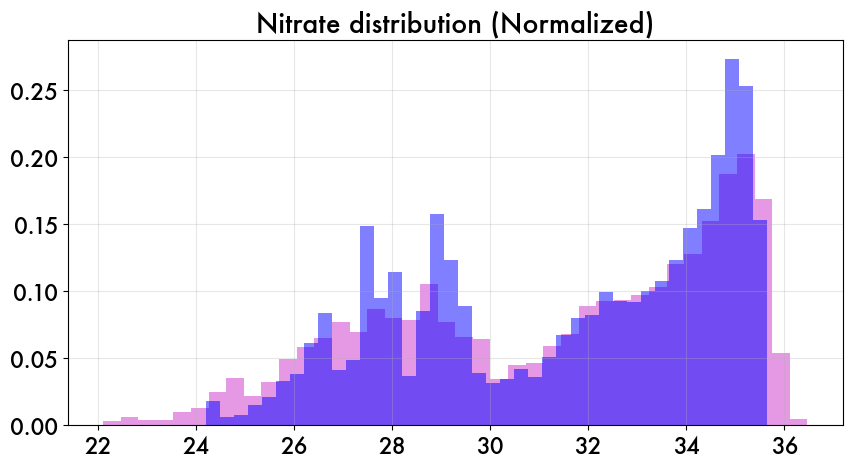

In [22]:
# Compare distributions between float and gliders
threshold = 1000
dfloat = floatDF[floatDF.pressure<threshold]

fig = plt.figure(figsize=(10,5))
plt.hist(dfloat.nitrate, bins=40, color='m', alpha=0.4, label="float", density=True)
plt.hist(dfloat[dfloat.wmoid == 5906030].nitrate, bins=40, color='b', alpha=0.5, label="float 6030", density=True)
plt.title('Nitrate distribution (Normalized)')
plt.grid(alpha=0.3, zorder=1)


(0.0, 3000.0)

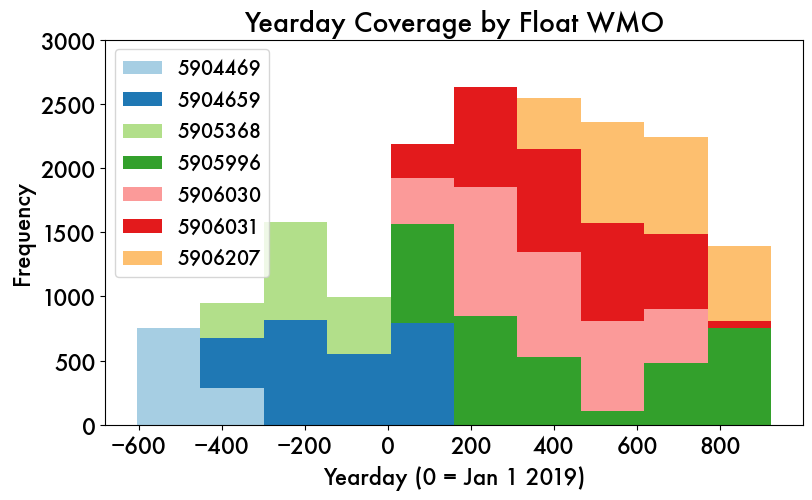

In [23]:
# Time coverage by Argo floats

pal = sns.color_palette("Paired")
sns.set_palette(pal)

fig = plt.figure(figsize=(9,5))
ax = plt.gca()
pd.DataFrame({k: v for k, v in floatDF.groupby('wmoid').yearday}).plot.hist(stacked=True, ax=ax) 
ax.legend(loc='upper left', fontsize=14)
ax.set_title('Yearday Coverage by Float WMO')
ax.set_xlabel('Yearday (0 = Jan 1 2019)')
ax.set_ylim([0, 3000])

In [24]:
dfcorr = floatDF.drop({'log_buoyancy', 'wmoid', 'ydcos', 'ydsin', 'profid', 'dist_maxb', 'o2sat'},axis=1).corr()
# plot a heatmap with annotation

plt.figure(figsize=(12,10))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(dfcorr, dtype=bool),k=1)
hm = sns.heatmap(dfcorr, mask=mask, annot=True, cmap='coolwarm', annot_kws={"size": 18}, center=0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')

KeyError: "['ydsin', 'ydcos'] not found in axis"

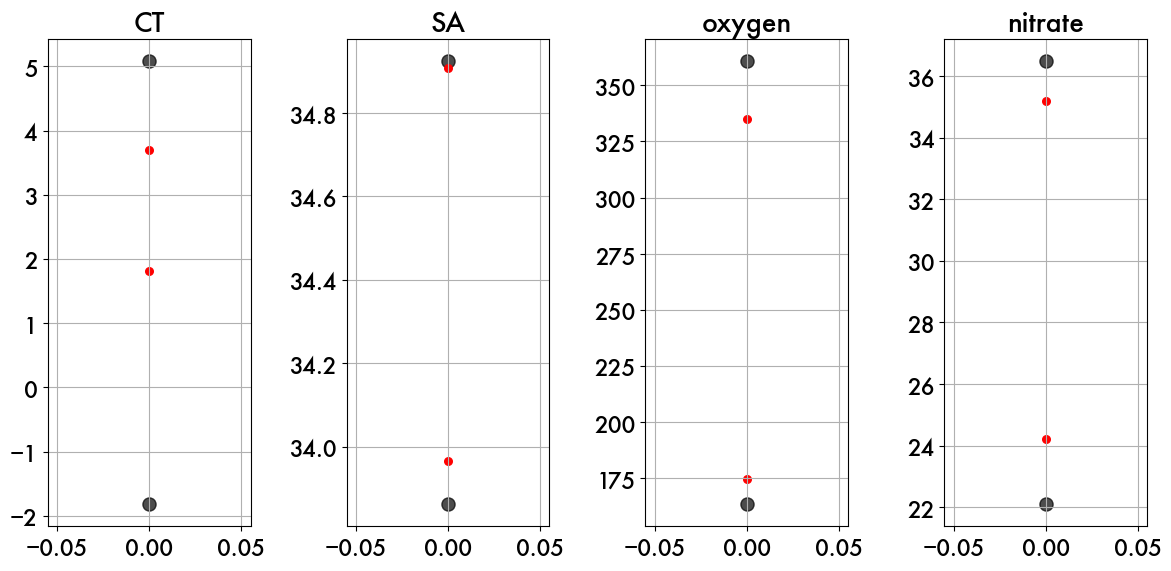

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(12,6), layout='tight')   
axs = axs.flatten()

others = floatDF[floatDF.wmoid!=5906030]
for i, var in enumerate(['CT' , 'SA', 'oxygen', 'nitrate']):
    minval = others[var].min()
    maxval = others[var].max()
    axs[i].scatter([0,0], [minval, maxval], c='k', alpha=0.7, s=90, label='others')
    axs[i].scatter([0,0], [sgfloat[var].min(), sgfloat[var].max()], c='r', s=30, label='sogos')
    # axs[i].scatter([0,0], [df_659[var].min(), df_659[var].max()], c='c', s=30, label='sg660')
    axs[i].set_title(var)
    axs[i].grid()


## 1.2 Setting up DataFrames with training variables

In [38]:
# Add last variables and set up final training data

# Add seasonal variable
def add_yd_sinusoids(DF):
    DF['ydcos'] = [sg.get_ydsines(x)[0] for x in DF.yearday.values]
    DF['ydsin'] = [sg.get_ydsines(x)[1] for x in DF.yearday.values]
    return DF

floatDF = add_yd_sinusoids(floatDF)
shipDF = add_yd_sinusoids(shipDF)

# Choose final features to be tested
tvars = ['yearday','lat','lon','pressure','CT', 'SA','oxygen', 'sigma0', 'log_buoyancy', 
         'spice','o2sat', 'ydcos', 'ydsin']
pvars = ['nitrate']  # prediction variable

# Take variables of interest
floatDF = floatDF[tvars + pvars + ['wmoid', 'profid', 'dist_maxb']].dropna()
shipDF = shipDF[tvars + pvars + ['profid', 'dist_maxb']].dropna() # dont drop on wmoid yet

print('# Ship observations (without NaNs): \t', shipDF.shape[0])
print('# Float observations (without NaNs ): \t', floatDF.shape[0])
print('# 5906030 observations (without NaNs): \t', floatDF[floatDF.wmoid==5906030].shape[0])

# Ship observations (without NaNs): 	 242
# Float observations (without NaNs ): 	 17644
# 5906030 observations (without NaNs): 	 3308


In [40]:
training

Unnamed: 0     yearday      lat      lon    pressure        CT  \
0               0 -603.853947 -54.2000  30.3510   17.540000  1.855033   
1               1 -603.853947 -54.2000  30.3510   22.119999  1.854044   
2               2 -603.853947 -54.2000  30.3510   31.470000  1.854344   
3               3 -603.853947 -54.2000  30.3510   33.329998  1.854252   
4               4 -603.853947 -54.2000  30.3510   45.660000  1.853641   
...           ...         ...      ...      ...         ...       ...   
11640         235  119.999306 -51.0071  29.9982  395.000000  2.878708   
11641         236  119.998611 -51.0069  29.9983  474.000000  2.808755   
11642         237  119.997222 -51.0067  29.9984  576.900000  2.724990   
11643         239  119.995139 -51.0065  29.9985  778.500000  2.508412   
11644         240  119.993750 -51.0064  29.9985  881.600000  2.515374   

              SA     oxygen     sigma0  log_buoyancy     spice       o2sat  \
0      34.127808  326.22037  27.156729    -17.809540 -0.588239  334.490032   
1      34.127803  326.00485  27.156800    -15.948689 -0.588326  334.498369   
2      34.127822  325.97280  27.156792    -17.868096 -0.588287  334.495852   
3      34.127827  325.43460  27.156803    -16.507311 -0.588292  334.496628   
4      34.127389  325.75323  27.156500    -14.547730 -0.588650  334.503079   
...          ...        ...        ...           ...       ...         ...   
11640  34.384321  224.40000  27.276426    -11.758693 -0.313815  325.424455   
11641  34.451509  209.70000  27.335976    -11.851089 -0.273374  325.816752   
11642  34.534497  193.40000  27.409255    -11.910586 -0.223118  326.281481   
11643  34.669959  175.70000  27.535630    -12.136740 -0.148627  327.691847   
11644  34.735776  172.60000  27.587353    -12.352624 -0.101646  327.467719   

          mncos     mnsin  month    nitrate      wmoid      profid   dist_maxb  
0     -0.866025  0.500000      5  27.304010  5904469.0  5904469085   94.469995  
1     -0.866025  0.500000      5  27.261232  5904469.0  5904469085   89.889996  
2     -0.866025  0.500000      5  27.312778  5904469.0  5904469085   80.539995  
3     -0.866025  0.500000      5  27.344120  5904469.0  5904469085   78.679997  
4     -0.866025  0.500000      5  27.111767  5904469.0  5904469085   66.349995  
...         ...       ...    ...        ...        ...         ...         ...  
11640 -0.500000  0.866025      4  32.230000        NaN          42 -251.800000  
11641 -0.500000  0.866025      4  33.200000        NaN          42 -330.800000  
11642 -0.500000  0.866025      4  34.170000        NaN          42 -433.700000  
11643 -0.500000  0.866025      4  34.740000        NaN          42 -635.300000  
11644 -0.500000  0.866025      4  34.070000        NaN          42 -738.400000  

[11645 rows x 19 columns]

- Note that the DataFrame `sgfloat` contains observations from the SOGOS float WMO 5906030. 

# PART 2: Splitting ML Data into Training, Validation, Testing

- Prepare data for RF development by subsampling and scaling. 



For BGC-Argo and GO-SHIP data, only observations up to depths of 1000 m are used to match the vertical range of the gliders. Random subsets with ~80% and ~20% of this data are used for training and simple holdout validation, respectively. When data are split into these subsets, observations from each profile are always kept together rather than sampling point observations individually. With this subsampling approach, each RF regressor is trained or validated on data containing complete vertical profiles, such that information about the local vertical structure is preserved. The training dataset consists of 11645 observations, and the validation dataset has 2933 observations. The test dataset from the withheld SOGOS float (WMO:5906030) has 3308 observations, from 16 profiles. All features are standardized to have unit variance and zero mean before training. The parameters of the standard scaler are determined from the training data and applied to the validation and testing data.

## 2.1 Subsample data into training, validation, and test sets

In [41]:
# Methods for subsampling

def split_profiles(floatDF, test_split = False):
    """ 
    @param floatDF: scaled dataframe with all float profiles
    @return: 
        training_data: training data (80% of profiles) with ship added
        validation_data: validation data (20% of profiles)
    
    This method treats a float profile like the smallest discrete "unit" upon which to train and validate the model.
    Our goal is to predict a water column (profile) rather than a discrete observation, so profiles are kept together while splitting.
    Note that test data will be all profiles from the SOGOS float when test_split is set as False by default.

    """

    # Create list of unique profile ID's and select random 80% for training
    profs = pd.unique(floatDF.profid)
    if 5906030 in profs:
        print('Warning: SOGOS float is in training data.')

    np.random.seed(42) 
    training_profid = np.random.choice(profs, int(np.floor(0.8*len(profs))), replace=False)
    training_data = floatDF[floatDF['profid'].isin(training_profid)]

    if test_split == False:
        # Take remaining profiles that were not in training set, for validation
        validation_profid = [x for x in profs if x not in training_profid]
        validation_data = floatDF[floatDF['profid'].isin(validation_profid)]
        test_data = [] # will become SOGOS data

    else:
        # Take HALF of remaining profiles that were not in training set, for validation (10% of total)
        profs_vt = [x for x in profs if x not in training_profid]  # remaining profiles after training data removed
        validation_profid= np.random.choice(profs_vt, int(np.floor(0.5*len(profs_vt))), replace=False)
        validation_data = floatDF[floatDF['profid'].isin(validation_profid)]

        test_profid = [x for x in profs_vt if x not in  validation_profid]
        test_data = floatDF[floatDF['profid'].isin(test_profid)]

    return training_data, validation_data, test_data

def split_ship(shipDF, test_split = False):
    """ 
    Split ship data into training and validation sets
    Stations are kept together (by index). 
    @param test_split: whether to split the 20% remaining into 10% test and 10% validation
    """
    ind = shipDF.index.values
    np.random.seed(42)
    
    training_ind = np.random.choice(ind, int(np.floor(0.8*len(ind))), replace=False)
    training_data = shipDF[shipDF.index.isin(training_ind)]

    if test_split == False:
        validation_ind = [x for x in ind if x not in training_ind]
        validation_data = shipDF[shipDF.index.isin(validation_ind)]
        test_data = [] # will become sogos float
    else:
        ind_vt = [x for x in ind if x not in training_ind]
        validation_ind = np.random.choice(ind_vt, int(np.floor(0.5*len(ind_vt))), replace=False)
        validation_data = shipDF[shipDF.index.isin(validation_ind)]
        
        test_ind = [x for x in ind_vt if x not in validation_ind]
        test_data = shipDF[shipDF.index.isin(test_ind)]
    
    return training_data, validation_data, test_data

In [42]:
# Split float and ship profiles separately. 

# Note that observations from vertical profiles are always kept together,
# since the goal oftraining is to predict vertical structure of the water column. 
[training_float, validation_float, empty] = split_profiles(floatDF[floatDF.wmoid!=5906030], test_split = False)
[training_ship, validation_ship, empty] = split_ship(shipDF, test_split = False)

training = pd.concat([training_float, training_ship], ignore_index=True)
validation = pd.concat([validation_float, validation_ship], ignore_index=True)
test = floatDF[floatDF.wmoid==5906030] # set SOGOS 

print('Subsampled Datasets: ')
# print('wmoids: ' + str(wmoids))
print('# training observations: \t' + str(len(training)))
print('# validation observations: \t' + str(len(validation)))
print('# test observations: \t\t' + str(len(test)))

Subsampled Datasets: 
# training observations: 	11645
# validation observations: 	2933
# test observations: 		3308


Comment on notation: 

We use `training` for unscaled and `training_scaled` for scaled observations.

## 2.2 Scaling Methods

- These are used internally within the main RF method in Section 2.2

In [43]:
def scale_features(df, training, type='StandardScaler'):
    """ Scale down glider dataset.
    @param: df: dataframe to scale
            type: type of scaler to use, 'StandardScaler' or 'MinMaxScaler'
    """

    cols_nonan = [col for col in df.columns if col not in ['profid', 'wmoid', 'AOU','dist_maxb']] # all columns to remove nans
    newdf = df.dropna(axis=0, subset=cols_nonan).copy()
    training_nonan = training.dropna(axis=0, subset=cols_nonan).copy()

    # Drop NaNs *EXCEPT* in the wmoid column, or else ship data is removed

    if type == 'StandardScaler':
        sca = preprocessing.StandardScaler().fit(training_nonan[cols_nonan])

    elif type == 'MinMaxScaler':
        sca = preprocessing.MinMaxScaler().fit(training_nonan[cols_nonan])

    df_scaled =  pd.DataFrame(sca.transform(newdf[cols_nonan]), columns=newdf[cols_nonan].columns)
    df_scaled['profid'] = newdf['profid'].values
    df_scaled['wmoid'] = newdf['wmoid'].values

    return df_scaled

In [34]:
def scale_down_tvt(training, validation, test, type='StandardScaler'):
    """ 
    Scale features using 
    @param: df: dataframe to scale
            type: type of scaler to use, 'StandardScaler' or 'MinMaxScaler'
    """
    # Don't remove NaNs in wmoid since ship will have empty field
    cols_nonan = [col for col in training.columns if col not in ['profid', 'wmoid', 'AOU','dist_maxb']] # all columns to remove nans

    training_nonan = training.dropna(axis=0, subset=cols_nonan).copy()
    validation_nonan = validation.dropna(axis=0, subset=cols_nonan).copy()
    test_nonan = test.dropna(axis=0, subset=cols_nonan).copy()

 
    # Scaler is built *USING TRAINING DATA* and applied to all
    if type == 'StandardScaler':
        sca = preprocessing.StandardScaler().fit(training_nonan[cols_nonan])

    elif type == 'MinMaxScaler':
        sca = preprocessing.MinMaxScaler().fit(training_nonan[cols_nonan])

    # Scale down all using the training scaler
    training_scaled = pd.DataFrame(sca.transform(training_nonan[cols_nonan]), columns=training_nonan[cols_nonan].columns)
    validation_scaled = pd.DataFrame(sca.transform(validation_nonan[cols_nonan]), columns=validation_nonan[cols_nonan].columns)
    test_scaled = pd.DataFrame(sca.transform(test_nonan[cols_nonan]), columns=test_nonan[cols_nonan].columns)

    # Add back profid, wmoids
    training_scaled['profid'] = training_nonan['profid'].values
    validation_scaled['profid'] = validation_nonan['profid'].values
    test_scaled['profid'] = test_nonan['profid'].values

    training_scaled['wmoid'] = training_nonan['wmoid'].values
    validation_scaled['wmoid'] = validation_nonan['wmoid'].values
    test_scaled['wmoid'] = test_nonan['wmoid'].values

    # Leave nitrate out of the scaler
    training_scaled['nitrate'] = training_nonan['nitrate'].values
    validation_scaled['nitrate'] = validation_nonan['nitrate'].values
    test_scaled['nitrate'] = test_nonan['nitrate'].values

    return training_scaled, validation_scaled, test_scaled


# PART 3: Random Forest Model Training / Feature Selection

## 3.1 Set up variable feature lists.

During training, we provide each version of the RF model with different ``feature lists", which are subsets of the available ocean parameters that can be used for training. Features such as conservative temperature (CT), absolute salinity (SA), potential density ($\sigma_0$), spice ($\tau$), Brunt-Vaisala buoyancy frequency ($N^2$), dissolved oxygen (O${_2}$), oxygen saturation, as well as coordinate features such as latitude (lat), longitude (lon), time, and season ($sz_1$ and $sz_2$) were considered. Spice is a measure of temperature and salinity variations, and acts as a tracer of water masses in the interior ocean. Of the models considered, results from a selection of seven models with increasing complexity are presented

In [28]:
# 3.3.1 Initialize variables to train the different models on 

var_list = {
            'Model_A': ['spice', 'sigma0'],
            'Model_B': ['CT', 'SA', 'pressure'], 
            'Model_C': ["CT", "SA", "pressure", 'oxygen'],
            'Model_D': ["CT", "SA", "pressure", "oxygen", 'lat', 'lon', 'yearday'],
            'Model_E': ["CT", "SA", 'pressure', 'oxygen', 'lat', 'lon', 'yearday', 'o2sat'],
            'Model_F': ["CT", "SA", 'pressure', 'oxygen', 'lat', 'lon', 'yearday', 'log_buoyancy'],
            'Model_G': ["CT", "SA", 'pressure', 'oxygen', 'lat', 'lon', 'yearday', 'ydcos', 'ydsin']
            }

model_list = list(var_list.keys())

# Create dictionary of features
allvars = []
for k in var_list.keys():
    allvars = allvars + var_list[str(k)]
allvars = pd.unique(allvars)

In [174]:
# Make Model palettes (mod April 2024)
model_palettes = {'columns':model_list}
model_palettes['Model_A'] = sns.color_palette('Purples')[3] #change for figures
model_palettes['Model_B'] = sns.color_palette('Reds')[4]
model_palettes['Model_C'] = sns.color_palette('Set2')[4]
 
model_palettes['Model_D'] = sns.color_palette('Blues')[4]
model_palettes['Model_E'] = sns.color_palette('Set2')[1] 
model_palettes['Model_F'] = sns.color_palette('Set2')[0]
model_palettes['Model_G'] = sns.color_palette('RdPu')[5]

## 3.2 Main Training Method

- Demonstrate Random Forest development using scikit-learn

Here, we demonstrate the method by which we train our RF model. 

Each RF regressor iswas constructed using the scikit-learn Python package with $n=1000$ trees, which is sufficiently large to constrain the estimates but computationally inexpensive. A maximum of 1/3 of total features were considered at each node \citep{james2013_Introduction}, with a minimum node sample size of 5 for a split to be considered. 

In [29]:
# Train the RF model. 

var_predict = 'nitrate'
def train_RF(var_list, training, validation, test, ntrees=1000, max_feats = 1/3, scaler='StandardScaler', min_samples_split=5):
    """ 
    Main method to train the RF model.
    Scaling of datasets to between 0 and 1 is done internally within the method.
    @param: 
        var_list: list of variables to use in the model
        training: training data unscaled, i.e. original range of values
        validation: validation data unscaled
        test: test data unscaled 
        ntrees: 1000 trees by default.

    @return:
        Mdl: trained RF model
        Mdl_MAE: Rescaled mean absolute error for training, validation, and test sets
        Mdl_IQR: Rescaled IQR for training, validation, and test sets
        DF_with_error: Rescaled dataframe with error metrics for the *TEST* set

    """

    Mdl = RandomForestRegressor(ntrees, max_features = max_feats, random_state = 0, bootstrap=False, min_samples_split=min_samples_split)
        #  max_features: use at most X features at each split (m~sqrt(total features)). ISSR.
        #  bootstrapping: *** Should be FALSE for geospatial data.

    # Drop NaN's without profid or wmoid
    cols_na = [col for col in training.columns if col not in ['profid', 'wmoid', 'AOU', 'dist_maxb']]
    training_nona = training.dropna(axis=0, subset=cols_na)  # makes same length as training_scaled
    validation_nona = validation.dropna(axis=0, subset=cols_na)
    test_nona = test.dropna(axis=0, subset=cols_na)

    # Scale features using the specified 'type' for each subset of data
    # Method drops Nan's internally. 
    # Note that scaler will NOT scale the target variable nitrate.
    [training_scaled, validation_scaled, test_scaled] = scale_down_tvt(training_nona, validation_nona, test_nona, type=scaler)

    # Create X Variables for each subset of data. Scale down. 
    X_training = training_scaled[var_list].to_numpy()
    X_validation = validation_scaled[var_list].to_numpy()
    X_test = test_scaled[var_list].to_numpy()

    # Nitrate remains unscaled as the target variable. 
    Y_training = training_nona[var_predict].to_numpy()
    Y_validation = validation_nona[var_predict].to_numpy()
    Y_test = test_nona[var_predict].to_numpy()

    # Train the model
    Mdl.fit(X_training, Y_training)

    # Estimate
    Y_pred_training = Mdl.predict(X_training)
    Y_pred_validation = Mdl.predict(X_validation)
    Y_pred_test = Mdl.predict(X_test)

    # Create dataframe for the test set with depth --> 
    DF_with_error = test_nona.copy(); 
    DF_with_error = DF_with_error.reset_index(drop=True)
    observed_nitrate = DF_with_error[var_predict].to_numpy()

    # Save new dataframe with test results
    DF_with_error['test_prediction'] = Y_pred_test
    DF_with_error['test_error'] = DF_with_error['test_prediction'] - observed_nitrate
    DF_with_error['test_relative_error'] = DF_with_error['test_error']/observed_nitrate

    # Error metrics
    AE_RF_training = np.abs(Y_pred_training - training_nona[var_predict])
    IQR_RF_training = iqr(abs(AE_RF_training))
    r2_RF_training = r2_score(training_nona[var_predict], Y_pred_training)

    # Return validation metrics
    AE_RF_validation = np.abs(Y_pred_validation - validation_nona[var_predict])
    IQR_RF_validation = iqr(abs(AE_RF_validation))
    r2_RF_validation = r2_score(validation_nona[var_predict], Y_pred_validation)

    validation_error = validation_nona.copy() #pd.DataFrame()
    validation_error['val_error'] = Y_pred_validation - validation_nona[var_predict]
    validation_error['val_relative_error'] = validation_error['val_error']/validation_nona[var_predict]

    AE_RF_test = np.abs(Y_pred_test - test_nona[var_predict]) # same as DF_with_error['test_error']
    IQR_RF_test = iqr(abs(AE_RF_test))
    r2_RF_test = r2_score(test_nona[var_predict], Y_pred_test)

    Mdl_MAE = [np.nanmedian(abs(AE_RF_training)), np.nanmedian(abs(AE_RF_validation)), np.nanmedian(abs(AE_RF_test))]
    Mdl_IQR = [IQR_RF_training, IQR_RF_validation, IQR_RF_test]
    Mdl_r2 = [r2_RF_training, r2_RF_validation, r2_RF_test]

    return [Mdl, Mdl_MAE, Mdl_IQR, Mdl_r2, DF_with_error, validation_error]


## 3.3 Running Random Forest

In [185]:
import class_RF 
importlib.reload(class_RF)
from class_RF import ModelVersion

In [186]:
# Train the models with chosen feature lists and hyperparameters.
ntrees=1000
max_feats = 1/3
min_samples_split = 5
scaler = 'StandardScaler'
# Bootstrap kept False for geospatial
description = 'Hyperparameters: trees=' + str(ntrees) + ', max_features=' + str(max_feats) + ', scaler=' + str(scaler)
print(description + '\n')

# Create the RF
RF_all = ModelVersion(model_list)
run_list = model_list # ['Model_A', 'Model_B', 'Model_C'] # change here if you only want to run a few.

for k in tqdm(run_list): 
    [RF_all.models[k], RF_all.MAE[k], RF_all.IQR[k], 
     RF_all.r2[k], RF_all.DF_err[k], 
     RF_all.val_err[k]] = train_RF(var_list[k], 
                            training, validation, test, 
                            ntrees = ntrees, max_feats = max_feats, scaler=scaler, 
                            min_samples_split=min_samples_split)
    
# To add another model to an existing ModelVersion
# RF_all.add('Model_K') 

Hyperparameters: trees=1000, max_features=0.3333333333333333, scaler=StandardScaler



100%|██████████| 7/7 [02:13<00:00, 19.09s/it]


In [45]:
# To save the test prediction values, can run below, changing save to True.
save = False
if save:
    float_6030 = test.copy()
    for k in ['Model_A', 'Model_B', 'Model_C', 'Model_D', 'Model_E', 'Model_F', 'Model_G']:
        temp = RF_ver[4][k]['test_prediction'].values
        float_6030[k] = temp

    # Save:
    float_6030.describe()
    float_6030.to_csv('../working-vars/RF-training/mlresult_wmo5906030_allpreds.csv')

In [ ]:
# To get back to results from here: 
# RF_ver = ModelVersion(model_list)

# list = []
# for mod in model_list:
#     list.append(pd.read_csv('../working-vars/RF-training/mlresult_' + mod + '_val_error'))
# dict_valerr = {k:v for k, v in zip(model_list, values)}
# RF_ver.val_err = dict_valerr

# list = []
# for mod in model_list:
#     list.append(pd.read_csv('../working-vars/RF-training/mlresult_' + mod + '_test_error'))
# dict_testerr = {k:v for k, v in zip(model_list, values)}
# RF_ver.DF_err = dict_testerr

# PART 4: Feature Importances

- Selecting best feature list for the Random Forest regressor

A **feature list** is the set of predictive variables given as inputs to the RF regressor; the values of these features are used to determine node conditions for each decision tree. Variables in a feature list can include observed parameters like pressure and $O_2$, or calculated parameters like buoyancy. 

A unique aspect of RF is that it returns a measure of **feature importance**, which reflects the predictive capability of on a given feature. The higher the feature importance, the greater reduction in target variable variance. A range of example models and their respective feature importances are shown below. We discuss why screening of validation errors is necessary for selecting a final feature list. 

## 4.0 Calculate Feature Importance Dictionary

In [ ]:
# Palette for plotting feature importance comparisons
pal = sns.color_palette('Set3', n_colors = 9)
dict = {'spice' : pal[2],
        'sigma0' : pal[3],
        'lat' : pal[0],
        'lon' : pal[8],
        # 'yearday' : pal[1],
        'oxygen' : pal[5],
        'CT' : pal[6],
        'SA' : pal[7],
        'pressure' : pal[4]}
        
pal = sns.color_palette('Set1', n_colors = 48)
pald = {k:v for k, v in zip(model_list, pal)}

In [ ]:
# Make total feature importance dictionary for plotting
dict = dict.fromkeys(allvars)
feat_imps = pd.DataFrame()

# Fill in feature importance
for ind, vkey in enumerate(model_list):
    for var in var_list[vkey]:
        feat_imps.at[ind, var] = RF_all.models[vkey].feature_importances_[var_list[vkey].index(var)]

feat_imps['Mdl'] = model_list
feat_imps = feat_imps.set_index('Mdl').fillna(np.nan)
feat_imps

# To save feature importance dataframe: 
# feat_imps.to_csv('../working-vars/RF-training/mlresult_feat_imps_' + desc + '.csv')

spice    sigma0        CT        SA  pressure    oxygen       lat  \
Mdl                                                                             
Model_A  0.417271  0.582729       NaN       NaN       NaN       NaN       NaN   
Model_B       NaN       NaN  0.169404  0.476596  0.354000       NaN       NaN   
Model_C       NaN       NaN  0.122787  0.321268  0.266088  0.289856       NaN   
Model_D       NaN       NaN  0.095765  0.365912  0.220721  0.285151  0.013100   
Model_E       NaN       NaN  0.079077  0.345466  0.216605  0.263456  0.010386   
Model_F       NaN       NaN  0.093799  0.337971  0.214502  0.263391  0.013022   
Model_G       NaN       NaN  0.083373  0.401470  0.200605  0.280240  0.010943   

              lon   yearday     o2sat  log_buoyancy     ydcos    ydsin  
Mdl                                                                     
Model_A       NaN       NaN       NaN           NaN       NaN      NaN  
Model_B       NaN       NaN       NaN           NaN       NaN      NaN  
Model_C       NaN       NaN       NaN           NaN       NaN      NaN  
Model_D  0.009825  0.009526       NaN           NaN       NaN      NaN  
Model_E  0.008815  0.008143  0.068051           NaN       NaN      NaN  
Model_F  0.010245  0.009863       NaN      0.057209       NaN      NaN  
Model_G  0.007427  0.006611       NaN           NaN  0.003991  0.00534

## 4.1 Feature Importance Plots

### Figure: Feature Importance Plot

Whereas the temporal and spatial features (latitude, longitude, and yearday) appear to have low feature importance, we find that their inclusion in the model reduces bias in the estimates and generally improves model performance as seen during model validation (Section 5). Our results suggest that feature importance alone cannot be used to determine final feature selection, and validation error distributions should be screened during training. An interpretation is that feature importance is biased towards the variable that reduces bin variance most at the first split; a predictor like latitude may help fine-tune the output, although it is a weak first-order predictor for nitrate concentration. 

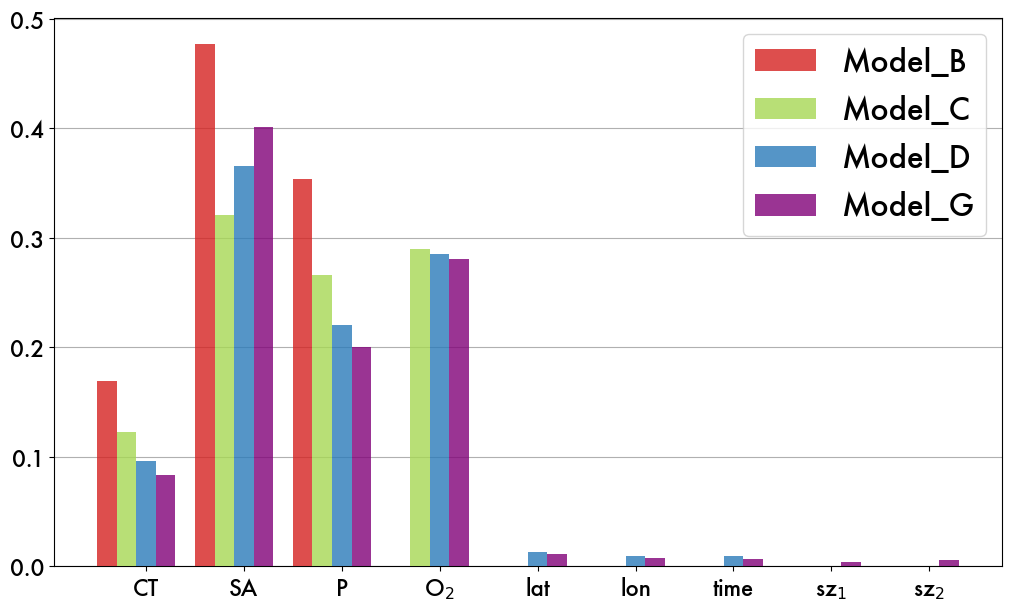

In [ ]:
# Make side by side comparisons between model (grouped by variable)

fig = plt.figure(figsize=(10,6), layout='constrained')
ax = fig.gca()
barwidth=.8

# To compare models B, C, D, and G:
modlist = ['Model_B', 'Model_C', 'Model_D', 'Model_G']
varslist = ['CT', 'SA', 'pressure', 'oxygen', 'lat', 'lon', 'yearday','ydcos', 'ydsin']
xlabel = ['CT', 'SA', 'P', 'O$_2$', 'lat', 'lon', 'time', 'sz$_{1}$', 'sz$_{2}$']

# To plot the simple models A through D
# modlist = model_list[:4]
# varslist = allvars[:-4]
# xlabel = ['spice', 'sigma0', 'CT', 'SA', 'pressure', 'oxygen', 'lat', 'lon', 'yearday']

# To plot the complex models D through G
# modlist = model_list[3:]
# varslist = allvars[2:]
# xlabel = ['CT', 'SA', 'pressure', 'oxygen', 'lat', 'lon', 'yearday',
#                     'o2sat','log(N2)', 'sz1', 'sz2']

# Result of plot method
xind = dict.fromkeys(modlist)
xind[modlist[0]] = np.arange(len(varslist))*len(modlist)

for i in range(len(modlist)-1):
    xind[modlist[i+1]] = [x + barwidth for x in xind[modlist[i]]]

for modtag in modlist:
    ax.bar(xind[modtag], feat_imps[varslist].loc[modtag].to_numpy(), color = model_palettes[modtag], alpha=0.8, label = modtag, zorder=3)

ax.grid(axis='y', zorder=0)
ax.legend(loc='upper right', fontsize=22)
ax.set_xticks(xind[modlist[2]]);
ax.set_xticklabels(varslist);
ax.set_xticklabels(xlabel);


# PART 5: RF Validation

## 5.1 Make error dictionaries

- Functions for organizing errors are found in `class_RF.py`

In [ ]:
importlib.reload(class_RF)
from class_RF import ModelVersion

In [ ]:
# Print error ranges from one model
RF_all.print_errors('Model_G', var ='test_relative_error', pres_lim= [0,1000])

Error metric: test_relative_error
Restricted to depths 0 to 1000:
median abs error: 	0.0064816826836161315
mean abs error 		0.008659518789473275

95% of errors fall between:
-0.02063 to 0.02474

During SOGOS between depths 0 to 1000:
95% of errors fall between:
-0.02338 to 0.03424


In [ ]:
# Print model metrics from all versions
model_metrics = ModelMetrics(RF_all)
model_metrics.print(sorted=False)

validation_MAE  validation_IQR  validation_r2  test_MAE  test_IQR  \
model                                                                        
Model_A        0.315131        0.463727       0.965829  0.309733  0.371379   
Model_B        0.266096        0.388199       0.978109  0.291118  0.350973   
Model_C        0.244489        0.354628       0.984262  0.244219  0.349177   
Model_D        0.142544        0.211059       0.993413  0.226967  0.328232   
Model_E        0.141166        0.214329       0.993572  0.222752  0.338766   
Model_F        0.147535        0.215698       0.993030  0.223896  0.326229   
Model_G        0.137654        0.203892       0.993602  0.204366  0.288493   

          test_r2  
model              
Model_A  0.969968  
Model_B  0.976983  
Model_C  0.975991  
Model_D  0.984299  
Model_E  0.984422  
Model_F  0.984479  
Model_G  0.986793

- We plot t

## 5.2 Plot Validation Errors

Text(0.5, 0, 'Relative Error %')

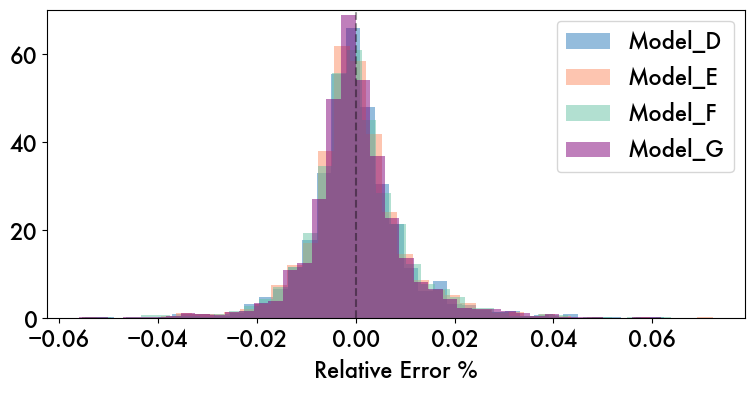

In [195]:
# Plot histogram of test or validation errors
tag = 'Model Validation Errors'
var = 'val_relative_error'
ymax=70

fig = plt.figure(figsize=(9,4))
ax = fig.gca()

for mod in model_list[-4:]:
    RF = RF_all.val_err[mod][var]
    ax.hist(RF, bins=40, alpha=0.5, color= model_palettes[mod], label=mod, density=True)

ax.vlines(0, ymin=0, ymax=ymax, colors='k', alpha=0.4, linestyles='dashed')
ax.set_ylim([0,ymax])

plt.legend()
ax.set_xlabel('Relative Error %')


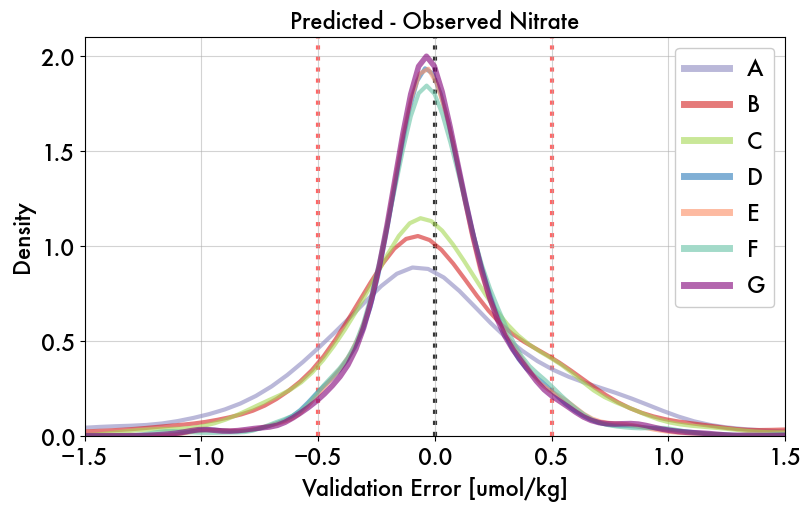

In [242]:
# KDE PROBABILITY DENSITY, VALIDATION ERRORS (FULL)

tag = 'Predicted - Observed Nitrate'
# var = 'val_relative_error'; ymax=70
var = 'val_error'; ymax=2.1
dat = RF_all.val_err


fig = plt.figure(figsize=(8,5), layout='constrained')
ax = fig.gca()

for mod in model_list[:]: 
    RF = dat[mod][var]

    # Add Gaussian KDE
    x = np.linspace(*RF.agg([min, max]), 100)
    kde = scipy.stats.gaussian_kde(RF)

    lw = 3; ls = 'solid'
    if mod == 'Model_G':
        lw=lw+1
    plt.plot(x, kde(x), color=model_palettes[mod], linewidth=lw, linestyle=ls, label=mod[-1], alpha=0.6)

# Show float uncertainty and 0 line
ax.axvline(x=0.5, color='r', linestyle='dotted', linewidth=3, alpha=0.6, zorder=0)
ax.axvline(x=-0.5, color='r', linestyle='dotted', linewidth=3, alpha=0.6, zorder=0)
ax.vlines(0, ymin=0, ymax=ymax, colors='k', alpha=0.8, linewidth=3, linestyle='dotted', zorder=1)
ax.set_ylim([0,ymax])
ax.grid(alpha=0.55, zorder=1)

# For relative, uncomment following section
ax.set_xlim([-1.5, 1.5])

plt.title(tag, fontsize=16)
ax.set_ylabel('Density')
ax.set_xlabel('Validation Error [umol/kg]')

#Legend
leg = plt.legend(fontsize=16, framealpha=1)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5)



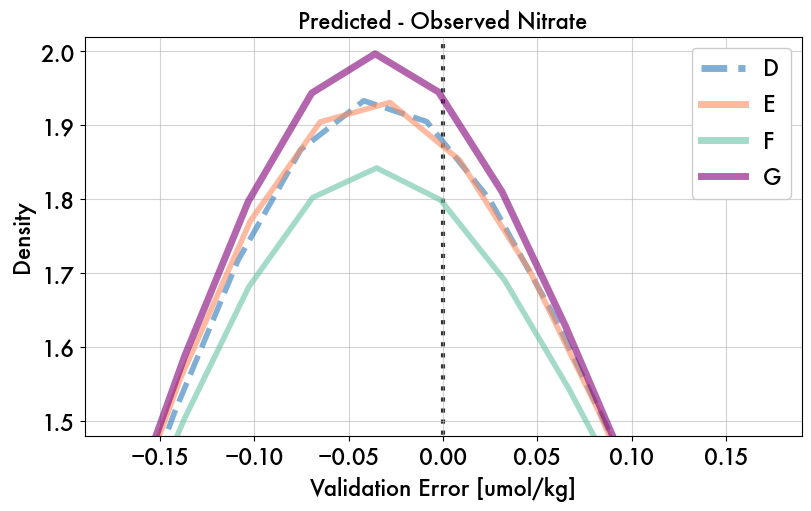

In [244]:
# INSET: KDE PROBABILITY DENSITY, VALIDATION ERRORS (ZOOM)
tag = 'Predicted - Observed Nitrate'
# var = 'val_relative_error'; ymax=70
var = 'val_error'; ymax=2.1
dat = RF_all.val_err


fig = plt.figure(figsize=(8,5), layout='constrained')
ax = fig.gca()

for mod in model_list[3:]: # ['Model_A', 'Model_G']: #
    RF = dat[mod][var]

    # Gaussian KDE
    x = np.linspace(*RF.agg([min, max]), 100)
    kde = scipy.stats.gaussian_kde(RF)

    lw = 4
    ls = 'solid'
    if mod == 'Model_G':
        lw=lw+1
    if mod in ['Model_D']:
        ls = '--'
    plt.plot(x, kde(x), color=model_palettes[mod], linewidth=lw, linestyle = ls, label=mod[-1], alpha=0.6)

# Show float uncertainty
ax.axvline(x=0.5, color='r', linestyle='--', linewidth=3, alpha=0.6, zorder=0)
ax.axvline(x=-0.5, color='r', linestyle='--', linewidth=3, alpha=0.6, zorder=0)
ax.vlines(0, ymin=0, ymax=ymax, colors='k', alpha=0.8, linewidth=3, linestyle='dotted', zorder=1)
ax.set_ylim([0,ymax])
ax.grid(alpha=0.55, zorder=1)

# SET LIMITS
# ax.set_xlim([-.48, 0.48])
# ax.set_ylim([0.5, 2.1])
ax.set_xlim([-.19, .19])
ax.set_ylim([1.48, 2.02])

plt.title(tag, fontsize=16)
ax.set_ylabel('Density')
ax.set_xlabel('Validation Error [umol/kg]')

#Legend
leg = plt.legend(fontsize=16, framealpha=1)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5)


Based on the distribution of validation errors, models D, E, and G have the best performance. If two models perform similarly, the one with fewer training variables is preferred to minimize overfitting, so the final model is chosen between D and G. The difference between these two versions is that model G includes additional seasonal variables as in Sharp et al. 2022. Since the seasonal component tends to improve estimates especially near the surface, we report the following cross-validation results for model G.

# PART 7: Cross Validation

One complication of applying RF to in-situ observations from autonomous profilers is that the training data are biased in space and time. As such, the training data are not perfectly representative of the regional dynamics and may cause overfitting during model development (Stock et al. 2022). We therefore use two other cross-validation metrics, k-fold and spatial leave-one-out, to assess the applicability of the chosen model.

## 7.1 K-Fold

In k-fold validation, the entire training dataset is split into random subsets of roughly equal size, called **folds**. We split the training data into k=10 folds, which was chosen to leave approximately 1000 point observations in each subset. Each fold is withheld as the validation set once while the model is trained on the other nine folds, such that there are 10 total iterations of the model. See Stock et al. (2022) for more details. 

In [236]:
def kfold_profiles(platDF, nfolds = 10):
        """
        @param platDF: scaled dataframe with all float and ship profiles
                nfolds: number of folds to split data into. 
                        Each fold will be used for validation once.
        @return folds_training: list of kfold dataframes for training
                folds_validation: list of kfold dataframes for validation

        """
        profs = pd.unique(platDF.profid)

        if 5906030 in profs:
                print('warning: 5906030 is in platDF')

        # Shuffle float profile ID's
        # Each element of fold_profs is a list of profile ID's belonging to the k-th fold
        np.random.seed(42) 
        rng = np.random.default_rng(); rng.shuffle(profs)
        fold_profs = np.array_split(profs, nfolds)

        # Make a dictionary of dataframes for validation and training. 
        # Each fold (1/nth of the total training data) will be used for validation once.
        # All profiles that are not part of that fold are used for training. 
        training_list = []; validation_list = []
        for i in np.arange(0,nfolds):
                df = platDF[platDF['profid'].isin(fold_profs[i])].copy()
                validation_list.append(df)

                df = platDF[~platDF['profid'].isin(fold_profs[i])].copy()
                training_list.append(df)

                
        folds_validation = {k:v for k, v in zip(np.arange(1,nfolds+1), validation_list)}
        folds_training = {k:v for k, v in zip(np.arange(1,nfolds+1), training_list)}

        return folds_training, folds_validation



In [237]:
#ftrain holds a list of kfold dataframes for training.
fdf = pd.concat([shipDF, floatDF])
fdf = fdf[fdf.wmoid!=5906030]
ftrain, fvalidation = kfold_profiles(fdf, nfolds=10)

In [ ]:
fold_list = np.arange(1,11)
folds = dict.fromkeys(fold_list)
folds_MAE = dict.fromkeys(fold_list)
folds_IQR = dict.fromkeys(fold_list)
folds_r2 = dict.fromkeys(fold_list)
folds_DF_err = dict.fromkeys(fold_list)
folds_val_err = dict.fromkeys(fold_list)

In [ ]:
class KFold:
    def __init__(self, nfolds=10)
    """ 
    """
        self.fold_list = fold_list = np.arange(1,nfolds+1)
        self.klist = {k: None for k in fold_list}
        self.MAE = {k: None for k in fold_list}
        self.IQR = {k: None for k in fold_list}
        self.r2 = {k: None for k in fold_list}
        self.DF_err = {k: None for k in fold_list}
        self.val_err = {k: None for k in fold_list}

In [ ]:
# Train the folds. 
# Choose which model to cross-validate on k folds.
kfold_mdl = 'Model_G'

# Check hyperparameters
description = 'ntrees=' + str(ntrees) + ', max_features=' + str(max_feats) + ', scaler=' + str(scaler)

print('Training RF k-folds: ' + description)
print('Model: ' + kfold_mdl)
for k in tqdm(fold_list):
    [folds[k], folds_MAE[k], folds_IQR[k], folds_r2[k], folds_DF_err[k], folds_val_err[k]] = train_RF(var_list[kfold_mdl], ftrain[k], fvalidation[k], test, 
                                                                                         ntrees = ntrees, max_feats = max_feats, scaler=scaler, min_samples_split= min_samples_split)

Training RF k-folds: ntrees=1000, max_features=0.3333333333333333, scaler=StandardScaler
Model: Model_H


100%|██████████| 10/10 [04:49<00:00, 28.98s/it]


In [ ]:
# Make k-fold error dictionaries
fvalidation_MAE = {k:v for k,v in zip(fold_list, [x[1][1].item() for x in folds_MAE.items()])}
fvalidation_IQR = {k:v for k,v in zip(fold_list, [x[1][1].item()  for x in folds_IQR.items()])}
fvalidation_r2 = {k:v for k,v in zip(fold_list, [x[1][1].item()  for x in folds_r2.items()])}

ftest_MAE = {k:v for k,v in zip(fold_list, [x[1][2].item()  for x in folds_MAE.items()])}
ftest_IQR = {k:v for k,v in zip(fold_list, [x[1][2].item()  for x in folds_IQR.items()])}
ftest_r2 = {k:v for k,v in zip(fold_list, [x[1][2].item()  for x in folds_r2.items()])}

# Printing sorted dictionary of VALIDATION errors
print('RF Parameters: ' + description + ' ' + desc + '\n')
print(kfold_mdl + ' k-fold Validation MAE:')
print_sorted(fvalidation_MAE)

print()
print('Mean error: ' + str(np.mean(np.fromiter(fvalidation_MAE.values(), dtype=float))))
print('Standard deviation: ' + str(np.std(np.fromiter(fvalidation_MAE.values(), dtype=float))))


# Printing sorted dictionary of errors
# print('RF Parameters: ' + description + ' ' + desc + '\n')
# print(kfold_mdl + ' k-fold Test MAE:')
# print_sorted(ftest_MAE)

# print()
# print('Mean error: ' + str(np.mean(list(ftest_MAE.values()))))
# print('Standard deviation: ' + str(np.std(list(ftest_MAE.values()))))


RF Parameters: ntrees=1000, max_features=0.3333333333333333, scaler=StandardScaler RF_ydsines

Model_H k-fold Validation MAE:
5  	0.11928085983324443
6  	0.12141470858335168
8  	0.1263026266249785
1  	0.13273254170833226
3  	0.13948820049996868
2  	0.14184853400003306
10  	0.14895953633332937
4  	0.1504354347916781
9  	0.15634203791659473
7  	0.15684608075000384

Mean error: 0.13936505610415145
Standard deviation: 0.0132468921765021


In [ ]:
# Save models and errors
print(kfold_mdl)

# for f in fold_list:
#     filename = '../working-vars/RF-training/k-fold/folds10_' + str(mod) + str(datetag) + '.csv'
#     models_DF_err[mod].to_csv(filename)

folds_metrics = pd.DataFrame([fvalidation_MAE, fvalidation_IQR, ftest_MAE, ftest_IQR], index=['fvalidation_MAE', 'fvalidation_IQR', 'ftest_MAE', 'ftest_IQR']).T
folds_metrics.to_csv('../working-vars/RF-training/mlcv_kfold_metrics_modG_' + desc + '.csv')


Model_H


Text(0.5, 1.0, 'Test MAE')

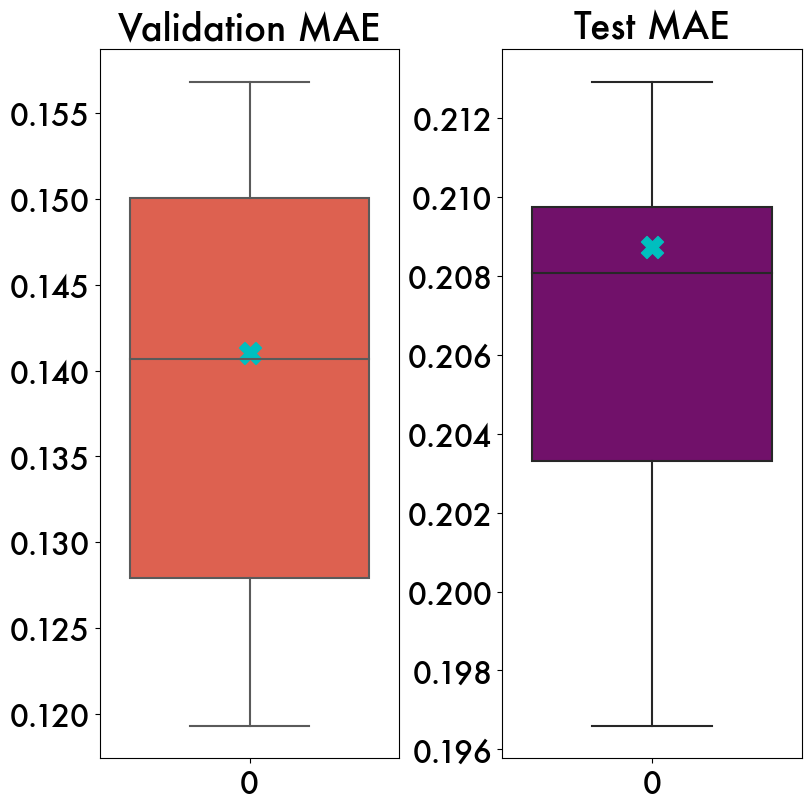

In [ ]:
#
fig, axs = plt.subplots(1,2,figsize=(8,8), layout='constrained', sharey=False)
axs = axs.flatten()

sns.boxplot(folds_metrics['fvalidation_MAE'].values, ax=axs[0],color=model_palettes['Model_D'])
axs[0].scatter([0], [0.141022], marker='X', s=250, c='c')
axs[0].set_title('Validation MAE')


sns.boxplot(folds_metrics['ftest_MAE'].values,  ax=axs[1], color=model_palettes['Model_G'])
axs[1].scatter([0], [0.208741], marker='X', s=250, c='c')
axs[1].set_title('Test MAE')


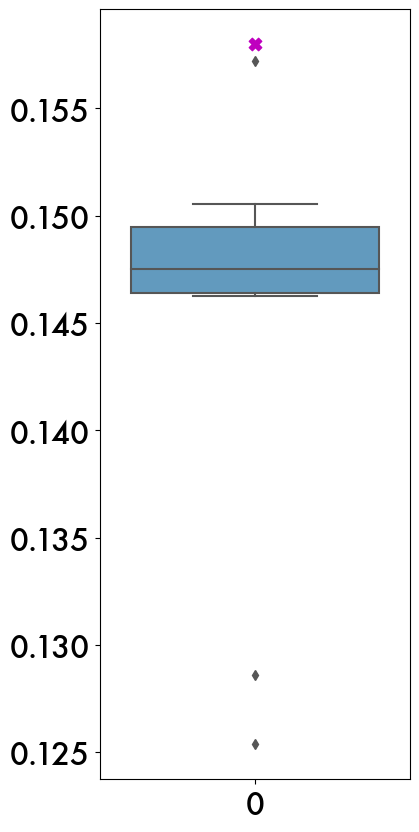

In [ ]:
# Temporary boxplot
fig = plt.figure(figsize=(4,10))
ax = plt.gca()

sns.boxplot(folds_metrics['fvalidation_MAE'].values, color=model_palettes['Model_F'])
ax.scatter([0], [0.157987], marker='X', s=80, c='m')

# ax.scatter([0], [0.235285], marker='X', s=130, c='yellow')


# col1 =  model_palettes['Model_F']
# bp = ax.boxplot(folds_metrics['fvalidation_MAE'].values, patch_artist = True) #, labels='validation MAE') #


In [ ]:
# notch shape box plot
bplot2 = ax2.boxplot(all_data,
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax2.set_title('Notched box plot')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)



## 7.2 LOO Spatial Blocking Validation of Float Data

- To use this section, make sure your training/val/test data is properly defined in section 2.1.2
- Use Leave One Out holdout validation

### Make additional "holdout" datasets for spatial blocking

- The particular training_holdout['5906030'], etc. are essentially the data we will be using to develop the model by running cell block 2.1.2
- That is, we want to make the training and validation from an 80/20 split of all the data except the SOGOS 

In [ ]:
# Create holdout dictionaries (wmo id as key means that wmo was withheld as test data)

wmos = [x for x in wmoids if x != 5906030]  # will not rerun for 5906030

training_holdout = dict.fromkeys(wmos)
validation_holdout = dict.fromkeys(wmos)
test_holdout = dict.fromkeys(wmos)

def make_holdout_tvt(floatDF, withheld = 5904659):
    """
    @param: 
        floatDF : full dataframe with profiles from all floats
                    we make a new variable, floatdat, to ensure we never train on the test data.
        withheld: the wmoid of the float to withhold as the test set (make sure this is an integer!)
                    note that the default is the SOGOS float
                    the default is the equivalent of training on all data except sogos and then testing on it
    @return:
        ** note that the returned data is left unscaled!
        training_data: training data (80% of left profiles) with ship added; scaled by split_profiles()
        validation_data: validation data (20% of left profiles) with ship added; scaled by split_profiles()
        test_data: test data (all profiles from the withheld float); scaled manually
    """

    # Training data will never include 5906030
    floatdat = floatDF[(floatDF.wmoid!=withheld) & (floatDF.wmoid!=5906030)]

    [training_float, validation_float, empty] = split_profiles(floatdat, test_split = False)
    [training_ship, validation_ship, empty] = split_ship(shipDF, test_split = False)

    # Add ship data to training and validation
    training_data = pd.concat([training_float, training_ship], ignore_index=True)
    validation_data = pd.concat([validation_float, validation_ship], ignore_index=True)

    # Test on withheld float profiles
    test_data = floatDF[floatDF.wmoid==withheld]

    return training_data, validation_data, test_data


# make holdout datasets from floats and add ship 
# keep track of #obs in each dataset
nobs_training = []; nobs_validation=[]; nobs_test=[]
for wmo in wmos: 
    [training_holdout[wmo], validation_holdout[wmo], test_holdout[wmo]] = make_holdout_tvt(floatDF, withheld = wmo)

    nobs_training.append(training_holdout[wmo].shape[0])
    nobs_validation.append(validation_holdout[wmo].shape[0])
    nobs_test.append(test_holdout[wmo].shape[0])

# Create dataframe to keep track of #obs from each spatial-block dataset
dict = {'wmoid withheld':wmos, 'training obs': nobs_training, 'validation obs': nobs_validation, 'test obs (from wmoid)': nobs_test}
nobs_holdout = pd.DataFrame(dict)
print("# observations for spatially blocked data:"); print(nobs_holdout)

# observations for spatially blocked data:
   wmoid withheld  training obs  validation obs  test obs (from wmoid)
0         5904469         10813            2724                   1041
1         5904659          9548            2486                   2544
2         5905368         10501            2589                   1488
3         5905996          8851            2241                   3486
4         5906031          9026            2296                   3256
5         5906207          9624            2433                   2521


- Note: each of the dictionaries training_holdout, validation_holdout, and test_holdout are UNSCALED down (original ranges) 
- The datasets are scaled down before training to between 0 and 1, but are kept unscaled here so that the results can be rescaled back to the correct original ranges of that particular training dataset

### Spatially Blocked Model Training on Feature List

In [ ]:
Mdl_holdout = dict.fromkeys(wmos)
MAE_holdout = dict.fromkeys(wmos) # each of these is in training, val, test order. 
IQR_holdout = dict.fromkeys(wmos)
r2_holdout = dict.fromkeys(wmos)
DF_err_holdout = dict.fromkeys(wmos)
val_error_holdout = dict.fromkeys(wmos)

Mdl = 'Model_H'

for wmo in tqdm(wmos):
    #Scaling is done internally within train_RF function
    [Mdl_holdout[wmo], MAE_holdout[wmo], IQR_holdout[wmo], r2_holdout[wmo], DF_err_holdout[wmo], val_error_holdout[wmo]] = train_RF(var_list[Mdl], 
                                                        training_holdout[wmo], validation_holdout[wmo], test_holdout[wmo],
                                                        ntrees=1000, max_feats = 1/3, scaler='StandardScaler')

100%|██████████| 6/6 [02:00<00:00, 20.01s/it]


In [ ]:
holdoutRF = [Mdl_holdout, MAE_holdout, IQR_holdout, r2_holdout, DF_err_holdout]
# loo_metrics = get_loo_metrics(holdoutRF)
loo_metrics = pd.DataFrame()
loo_metrics['validation_MAE'] = [x[1][1].item() for x in MAE_holdout.items()]
loo_metrics['validation_IQR'] = [x[1][1].item() for x in IQR_holdout.items()]
loo_metrics['validation_r2'] = [x[1][1].item() for x in r2_holdout.items()]

loo_metrics['test_MAE'] = [x[1][2].item() for x in MAE_holdout.items()]
loo_metrics['test_IQR'] = [x[1][2].item() for x in IQR_holdout.items()]
loo_metrics['test_r2'] = [x[1][2].item() for x in r2_holdout.items()]

loo_metrics['withheld'] = Mdl_holdout.keys()
loo_metrics.set_index('withheld', inplace=True)

print('Model metrics for each holdout using ' + Mdl + ':')
print(description)
loo_metrics

Model metrics for each holdout using Model_H:
ntrees=1000, max_features=0.3333333333333333, scaler=StandardScaler


validation_MAE  validation_IQR  validation_r2  test_MAE  test_IQR  \
withheld                                                                      
5904469         0.125954        0.189972       0.993975  0.348288  0.362124   
5904659         0.143324        0.219630       0.994209  0.398289  0.451920   
5905368         0.147002        0.208029       0.992011  0.298294  0.276604   
5905996         0.141714        0.216415       0.992072  0.566417  0.552156   
5906031         0.139436        0.197836       0.994531  0.639973  0.419914   
5906207         0.145009        0.202105       0.993408  0.210134  0.299430   

           test_r2  
withheld            
5904469   0.958854  
5904659   0.970939  
5905368   0.984332  
5905996   0.970287  
5906031   0.944773  
5906207   0.983809

In [ ]:
model_metrics

validation_MAE  validation_IQR  validation_r2  test_MAE  test_IQR  \
model                                                                        
Model_G        0.141022        0.204308       0.993847  0.208741  0.299928   
Model_D        0.141331        0.211370       0.993471  0.230674  0.337591   
Model_E        0.142409        0.214952       0.993515  0.217932  0.334644   
Model_F        0.144876        0.213796       0.993131  0.227044  0.330526   
Model_C        0.239698        0.354687       0.984250  0.247276  0.352181   
Model_B        0.266184        0.390613       0.978052  0.294011  0.352974   
Model_A        0.311713        0.477562       0.964485  0.318502  0.376563   

          test_r2  
model              
Model_G  0.985812  
Model_D  0.984072  
Model_E  0.984471  
Model_F  0.984484  
Model_C  0.975649  
Model_B  0.976448  
Model_A  0.968674

Text(0.5, 1.0, 'Test MAE')

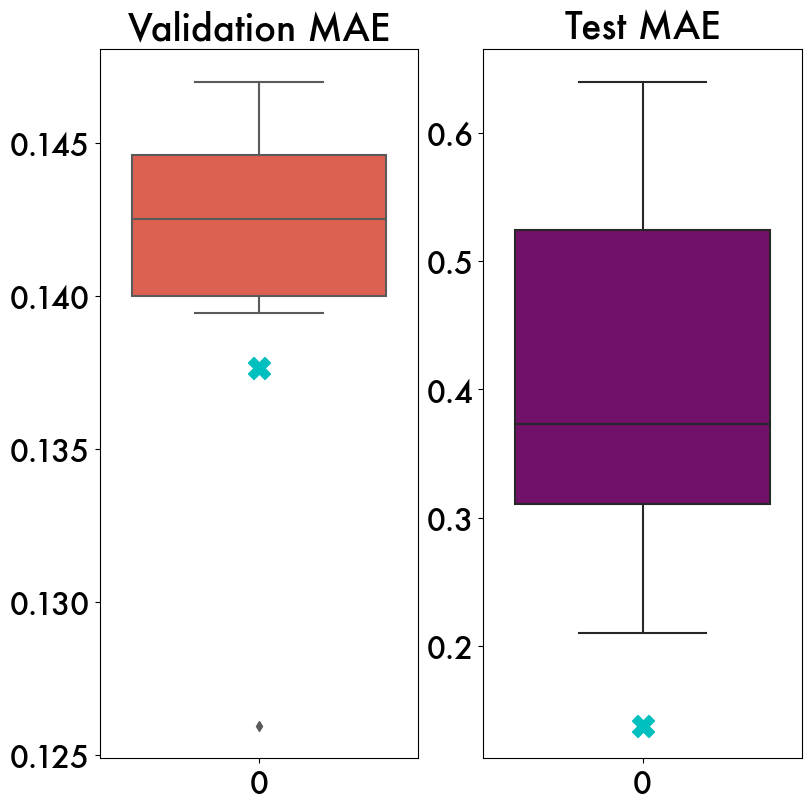

In [ ]:
# temporary boxplot
# fig = plt.figure(figsize=(4,10))
# ax = plt.gca()


fig, axs = plt.subplots(1,2,figsize=(8,8), layout='constrained', sharey=False)
axs = axs.flatten()

sns.boxplot(loo_metrics['validation_MAE'].values, ax=axs[0],color=model_palettes['Model_D'])
axs[0].scatter([0], [0.137654], marker='X', s=250, c='c')
axs[0].set_title('Validation MAE')


sns.boxplot(loo_metrics['test_MAE'].values,  ax=axs[1], color=model_palettes['Model_G'])
axs[1].scatter([0], [0.137654], marker='X', s=250, c='c')
axs[1].set_title('Test MAE')


In [ ]:
# Save loo metrics
loo_metrics.to_csv('../working-vars/RF-training/mlcv_spatialLOO_metrics_modG_' + desc + '.csv')

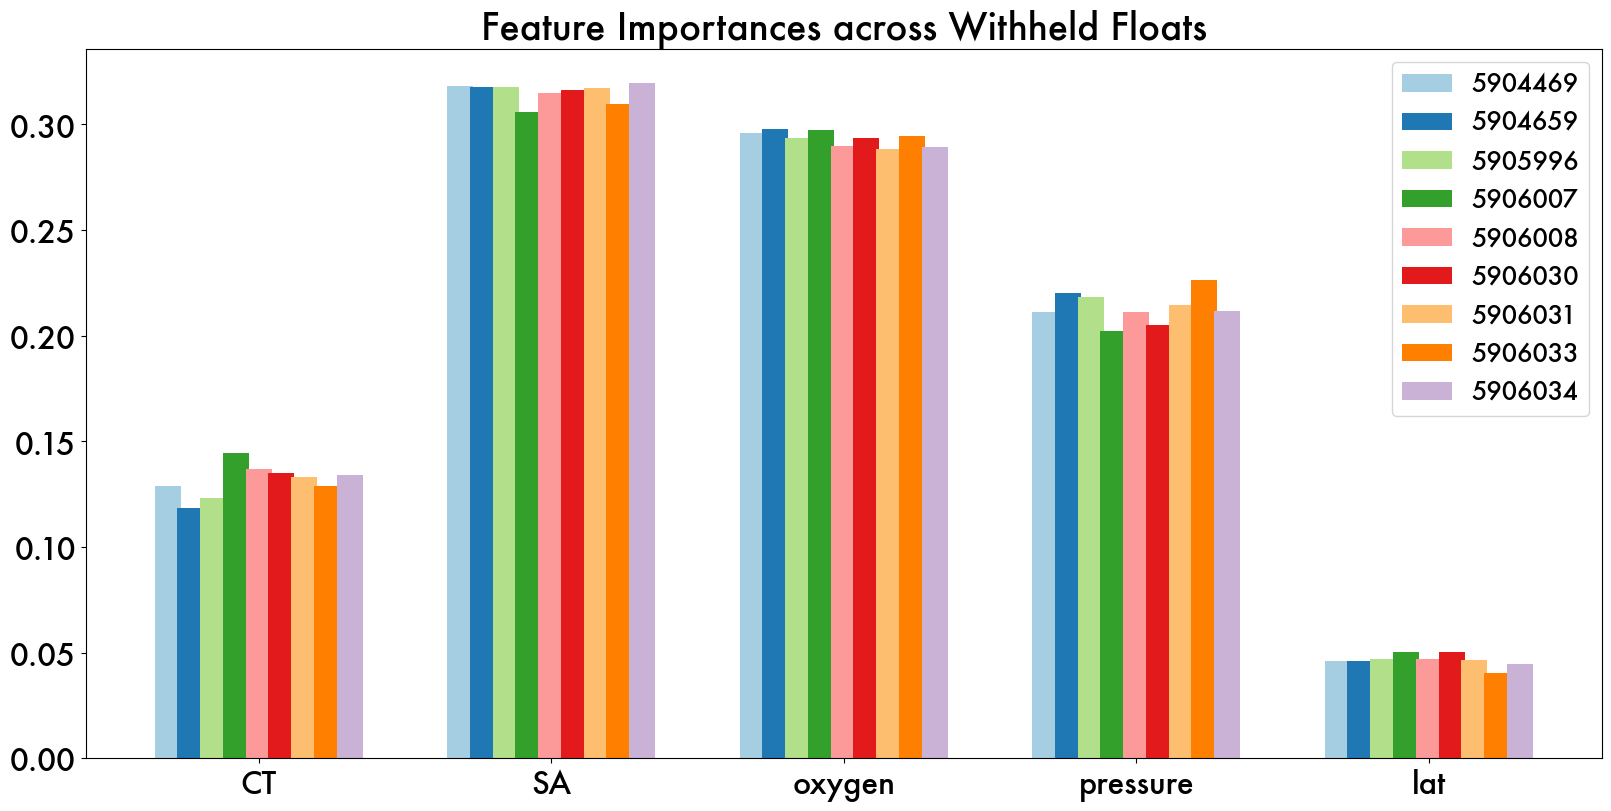

In [ ]:
# Compare feature importance across LOO iterations for a given model
fig = plt.figure(figsize=(16,8), layout='constrained')
ax = fig.gca()

barwidth=.7

xind = dict.fromkeys(wmoids)
xind[wmoids[0]] = np.arange(5)*9
for i in range(8):
    xind[wmoids[i+1]] = [x + barwidth for x in xind[wmoids[i]]]

for wmo in wmoids:
    ax.bar(xind[wmo], Mdl_holdout_5[wmo].feature_importances_, label=wmo, color=wmo_colors[wmo])

### 

# x = np.arange(5)*10  # the label locations
# width = 0.75  # the width of the bars
# multiplier = 0
ax.set_xticks(xind[wmoids[4]])
ax.set_xticklabels(var_list['Mdl_5B'])
ax.set_title('Feature Importances across Withheld Floats')
ax.legend()

In [ ]:
# Test a spatial LOO model on SOGOS float:
platDF = test
Mdl = Mdl_holdout[5906008]

platDF = platDF[tvars+['profid', 'wmoid']]
cols_na = [col for col in platDF.columns if col not in ['profid', 'wmoid']]
platDF_nona = platDF.dropna(axis=0, subset=cols_na) 

platDF_scaled = scale_features(platDF, training, type='StandardScaler')
X_plat= platDF_scaled[var_list['Mdl_28t']].to_numpy()
Y_plat = Mdl.predict(X_plat)


Y_pred = rescale_target(Y_plat, training_holdout[5906008][var_predict], type='StandardScaler')

sgtest = test.dropna(axis=0, subset=cols_na).copy()
sgtest['test_prediction'] = Y_pred
sgtest['test_error'] = sgtest['test_prediction'] - sgtest[var_predict]
sgtest['test_relative_error'] = sgtest['test_error']/sgtest[var_predict]
print(np.abs(sgtest.test_error).median())


0.48465583096586684


# PART 5: RF Error Analysis

## 5.2 Plot Error Distributions (Histograms)

Text(0.5, 1.0, 'Comparison of Nitrate Distributions for SOGOS Platforms')

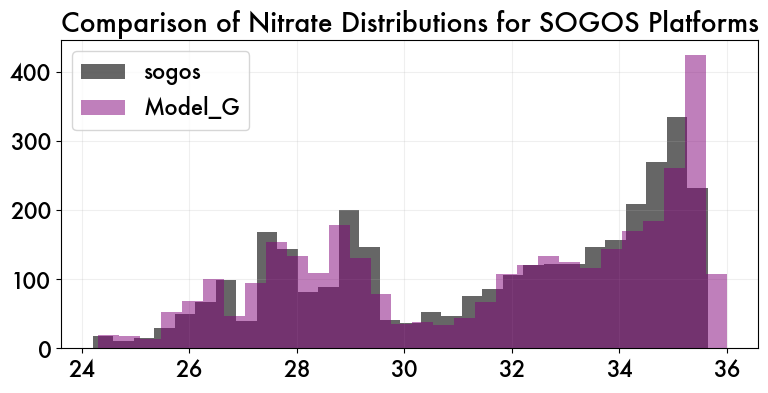

In [208]:
# Plot nitrate distributions
mod = 'Model_G'
dat = RF_all.DF_err[mod]
fig = plt.figure(figsize=(9,4))
ax = fig.gca()

ax.grid(zorder=0, alpha=0.2)
plt.hist(dat['nitrate'], bins=30, alpha=0.6, label='sogos', color='k', zorder=1)
plt.hist(dat['test_prediction'], bins=30, alpha=0.5, label=mod, color=model_palettes[mod], zorder=3)
    
plt.legend()
ax.set_title('Comparison of Nitrate Distributions for SOGOS Platforms')

## 5.3 Plot Error Sections (Time-Depth)

Text(0.5, 1.0, 'RF Nitrate Prediction')

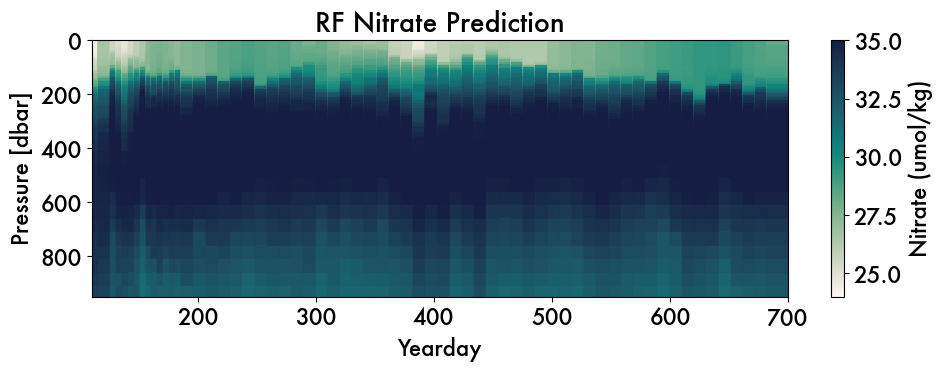

In [212]:
# Section of Model G prediction
dat = RF_all.DF_err['Model_G']
fig  = plt.figure(figsize=(10,4), tight_layout=True)
ax = plt.gca()

sca = ax.scatter(dat.yearday, dat.pressure, c=dat.test_prediction, cmap=cmo.tempo, s=250, marker='s', vmin=24, vmax=35)
plt.colorbar(sca, ax=ax).set_label('Nitrate (umol/kg)')

ax.invert_yaxis()
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')

ax.set_xlim([110,700])
ax.set_ylim([950,0])
ax.set_title('RF Nitrate Prediction')

# plt.savefig('../figures/ModelG_observation_profmap.png', dpi=300, bbox_inches='tight')

(950.0, 0.0)

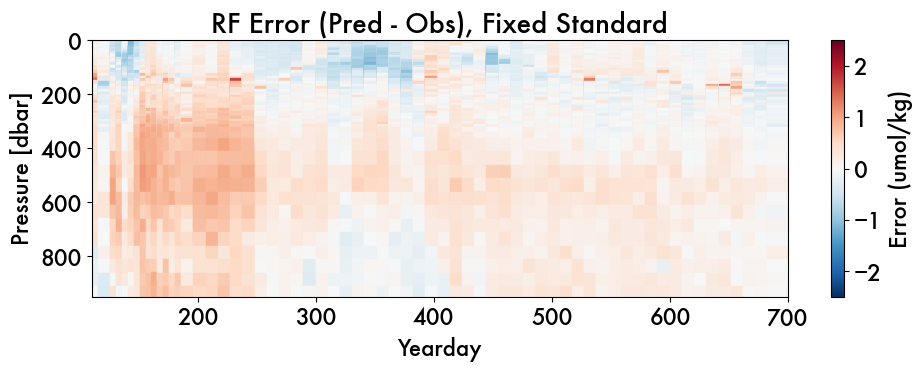

In [216]:
# SINGLE ERROR PROFILE
dat = RF_all.DF_err['Model_G']

fig  = plt.figure(figsize=(10,4), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.test_error, cmap='RdBu_r', s=250, marker='s' , vmin=-2.5, vmax=2.5)
plt.colorbar(sca, ax=ax).set_label('Error (umol/kg)')

ax.set_title('RF Error (Pred - Obs), Fixed Standard')
ax.invert_yaxis()
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')

ax.set_xlim([110,700])
ax.set_ylim([950,0])


(950.0, 0.0)

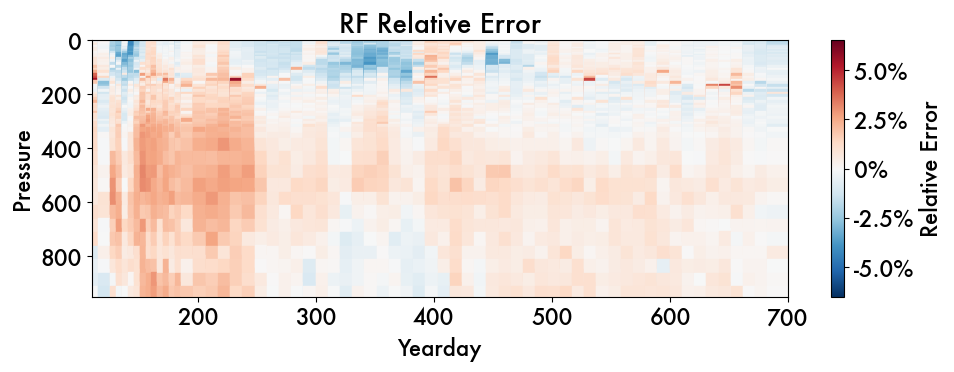

In [219]:
# SINGLE TEST RELATIVE ERROR PROFILE
dat = RF_all.DF_err['Model_G']

fig  = plt.figure(figsize=(10,4), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.test_relative_error, cmap='RdBu_r', s=250, marker='s', vmin=-.065, vmax=.065)

# ticklist = [-0.04, -0.02, 0, 0.02, 0.04] 
ticklist = [-0.05, -0.025, 0, 0.025, 0.05]
cbar = plt.colorbar(sca, ax=ax, ticks=ticklist) # [-0.28, -0.025, 0, 0.025, 0.28]
cbar.ax.set_yticklabels(['-5.0%', '-2.5%', '0%', '2.5%', '5.0%'])  # Setting tick labels here
cbar.set_label('Relative Error') 

ax.set_title('RF Relative Error')
ax.invert_yaxis()
ax.set_ylabel('Pressure')
ax.set_xlabel('Yearday')
# ax.set_xlim([120, 550])
# ax.set_ylim([600,0])

ax.set_xlim([110,700])
ax.set_ylim([950,0])


## 5.4 Plot Subplot Comparison Sections

Text(0.5, 0, 'Yearday')

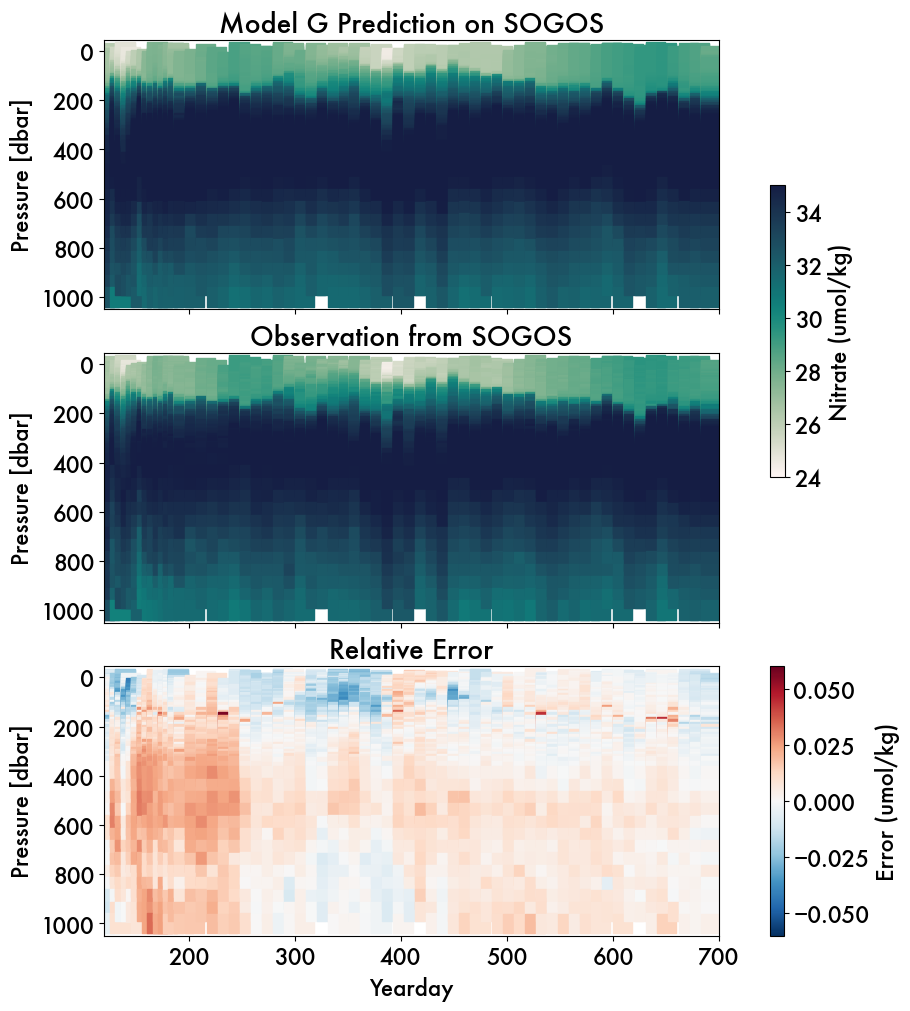

In [230]:
# * 3 Subplots: Prediction, Obs, and Error Profiles
dat = RF_all.DF_err['Model_G']
tag = 'Model G'
type = 'relative' # Choose absolute or relative errors here


fig, axs = plt.subplots(3,1, figsize=(9,10), layout='constrained', sharex=True)
axs = axs.flatten()

sca0 = axs[0].scatter(dat.yearday, dat.pressure, c=dat.test_prediction, cmap=cmo.tempo, s=200, marker='s', vmin=24, vmax=35) #, vmin=0, vmax=0.005
axs[0].set_title(tag + ' Prediction on SOGOS')

sca1 = axs[1].scatter(dat.yearday, dat.pressure, c=dat.nitrate, cmap=cmo.tempo, s=200, marker='s', vmin=24, vmax=35) #, vmin=0, vmax=0.005
axs[1].set_title('Observation from SOGOS') 

fig.colorbar(sca0, ax=axs[0:2], shrink=0.5).set_label('Nitrate (umol/kg)')

if type == 'absolute':
    sca2 = axs[2].scatter(dat.yearday, dat.pressure, c=dat.test_error, cmap='RdBu_r', s=200, marker='s', vmin=-2.5, vmax=2.5)
    axs[2].set_title('Error (Prediction - Observation)')
    fig.colorbar(sca2, ax=axs[2]).set_label('Error (umol/kg)')

elif type == 'relative':
    sca2 = axs[2].scatter(dat.yearday, dat.pressure, c=dat.test_relative_error, cmap='RdBu_r', s=200, marker='s', vmin=-.06, vmax=.06)
    axs[2].set_title('Relative Error')
    ticklist = [-0.05, -0.025, 0, 0.025, 0.05] 
    cbar = plt.colorbar(sca2, ax=axs[2], ticks=ticklist).set_label('Error (umol/kg)')

for ax in axs:
    ax.invert_yaxis()
    ax.set_ylabel('Pressure [dbar]')
    ax.set_xlim([120,700])

axs[2].set_xlabel('Yearday')


## 5.5 Plot Model Bias by Depth 

Text(0.5, 1.0, 'Model E- SOGOS Test Error')

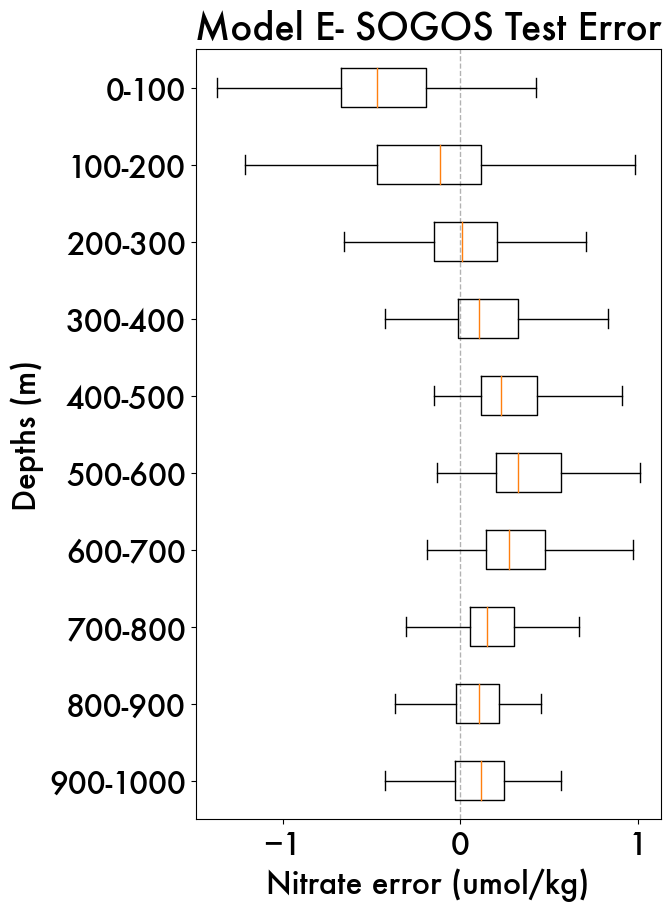

In [ ]:
tag = "Model E"
dat = RF_ver19[4]['Model_E']

testerr= {
    "0-100": dat[(dat["pressure"] >= 0) & (dat["pressure"] < 100)]["test_error"].values,
    "100-200": dat[(dat["pressure"] >= 100) & (dat["pressure"] < 200)]["test_error"].values,
    "200-300": dat[(dat["pressure"] >= 200) & (dat["pressure"] < 300)]["test_error"].values,
    "300-400": dat[(dat["pressure"] >= 300) & (dat["pressure"] < 400)]["test_error"].values,
    "400-500": dat[(dat["pressure"] >= 400) & (dat["pressure"] < 500)]["test_error"].values,
    "500-600": dat[(dat["pressure"] >= 500) & (dat["pressure"] < 600)]["test_error"].values,
    "600-700": dat[(dat["pressure"] >= 600) & (dat["pressure"] < 700)]["test_error"].values,
    "700-800": dat[(dat["pressure"] >= 700) & (dat["pressure"] < 800)]["test_error"].values,
    "800-900": dat[(dat["pressure"] >= 800) & (dat["pressure"] < 900)]["test_error"].values,
    "900-1000": dat[(dat["pressure"] >= 900) & (dat["pressure"] < 1000)]["test_error"].values
}

labels, data = testerr.keys(), testerr.values()

fig = plt.figure(figsize=(6,10))
ax = fig.gca()
ax.boxplot(data, vert=False, showfliers=False, widths=0.5)
ax.invert_yaxis()
ax.axvline(x=0, color='k', alpha=0.3, linestyle='--', linewidth=1, zorder=0)


plt.yticks(range(1, len(labels) + 1), labels)
plt.ylabel("Depths (m)")
plt.xlabel("Nitrate error (umol/kg)")
plt.title(tag + "- SOGOS Test Error")
# plt.xlim(-0.025, 0.025)

In [231]:
def get_depth_bias(data, ranges):
    return {f"{start}-{end}": data[(data["pressure"] >= start) & (data["pressure"] < end)]["test_error"].values
            for start, end in ranges}

pressure_ranges = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500),
                   (500, 600), (600, 700), (700, 800), (800, 900), (900, 1000)]

mod_one = 'Model_D'
mod_two = 'Model_G'

dat_one = RF_all.DF_err[mod_one]
testerr_one = get_depth_bias(dat_one, pressure_ranges)

dat_two = RF_ver[4][mod_two]
testerr_two = get_depth_bias(dat_two, pressure_ranges)

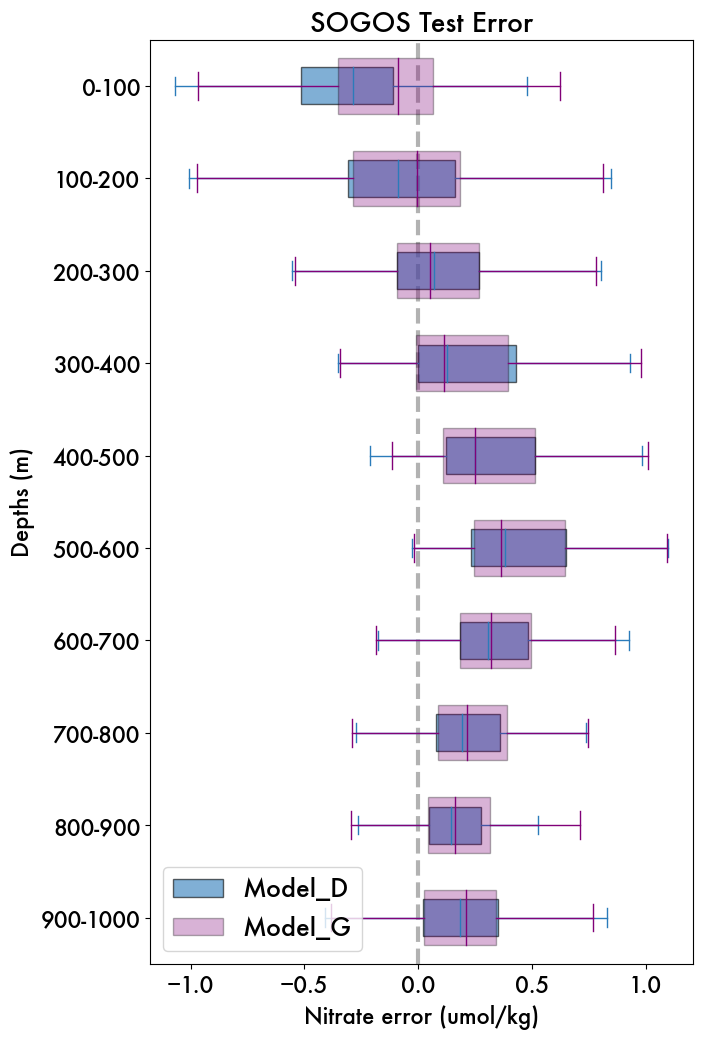

In [235]:
# GOOD VERISON: Compare two models 

mod_one = 'Model_D'
mod_two = 'Model_G'

dat_one = RF_all.DF_err[mod_one]
testerr_one = get_depth_bias(dat_one, pressure_ranges)

dat_two = RF_ver[4][mod_two]
testerr_two = get_depth_bias(dat_two, pressure_ranges)

# Colors
color_one = model_palettes['Model_D'] # sns.color_palette("Purples")[3]
color_two = model_palettes['Model_G']
col_one = {'color':color_one, 'linewidth':1}
col_two = {'color':color_two, 'linewidth':1}

# Make figure 
fig = plt.figure(figsize=(7,12))
ax = fig.gca()

bplot_one = ax.boxplot(testerr_one.values(), vert=False, showfliers=False, widths=0.4, 
                    patch_artist=True, boxprops={'facecolor':color_one, 'alpha':0.6},
                    medianprops=col_one,
                    capprops=col_one,
                    whiskerprops=col_one,
                    flierprops=col_one)

bplot_two = ax.boxplot(testerr_two.values(), vert=False, showfliers=False, widths=0.6, 
                    patch_artist=True, boxprops={'facecolor':model_palettes[mod_two], 'alpha':0.3, 'edgecolor':'k'},
                    medianprops= col_two,
                    capprops=col_two,
                    whiskerprops=col_two,
                    flierprops=col_two)



ax.invert_yaxis()
ax.axvline(x=0, color='k', linestyle='--', linewidth=3, alpha=0.3, zorder=0)

labels = testerr_one.keys()
plt.yticks(range(1, len(labels) + 1), labels)
plt.ylabel("Depths (m)")
plt.xlabel("Nitrate error (umol/kg)")
plt.title("SOGOS Test Error")

ax.legend([bplot_one["boxes"][0], bplot_two["boxes"][0]], [mod_one, mod_two], loc='lower left', fontsize=18)

## 5.6 Plot Scatterplots (Also T-S space)

- T-S Space
- Isopycnals

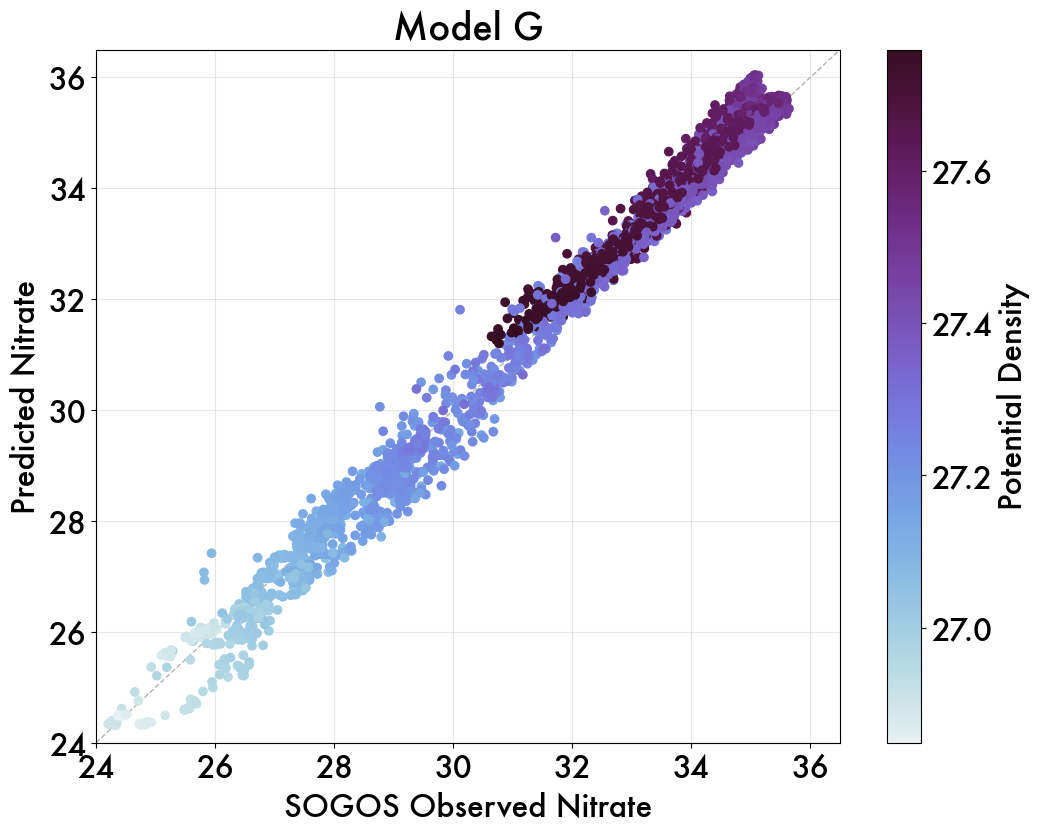

In [ ]:
# Prediction Error as function of observed nitrate 1:1
df = RF_ver[4]['Model_G']
tag = 'Model G'


fig = plt.figure(figsize=(12,9))
ax = fig.gca()
plt.scatter(df.nitrate, df.test_prediction, c=df.sigma0, cmap=cmo.dense, zorder=3)
plt.plot([0, 40], [0, 40], 'k--', linewidth=1, alpha=0.3, zorder=0)
cbar = plt.colorbar()
cbar.set_label('Potential Density')
ax.set_xlabel('SOGOS Observed Nitrate')
ax.set_ylabel('Predicted Nitrate')
ax.set_title(tag)
ax.set_ylim(24, 36.5)
ax.set_xlim(24, 36.5)
ax.grid(alpha=0.3, zorder=1)


## 6.1 Plotting in T-S Space

Text(0.5, 1.0, 'Test Prediction Errors Model G')

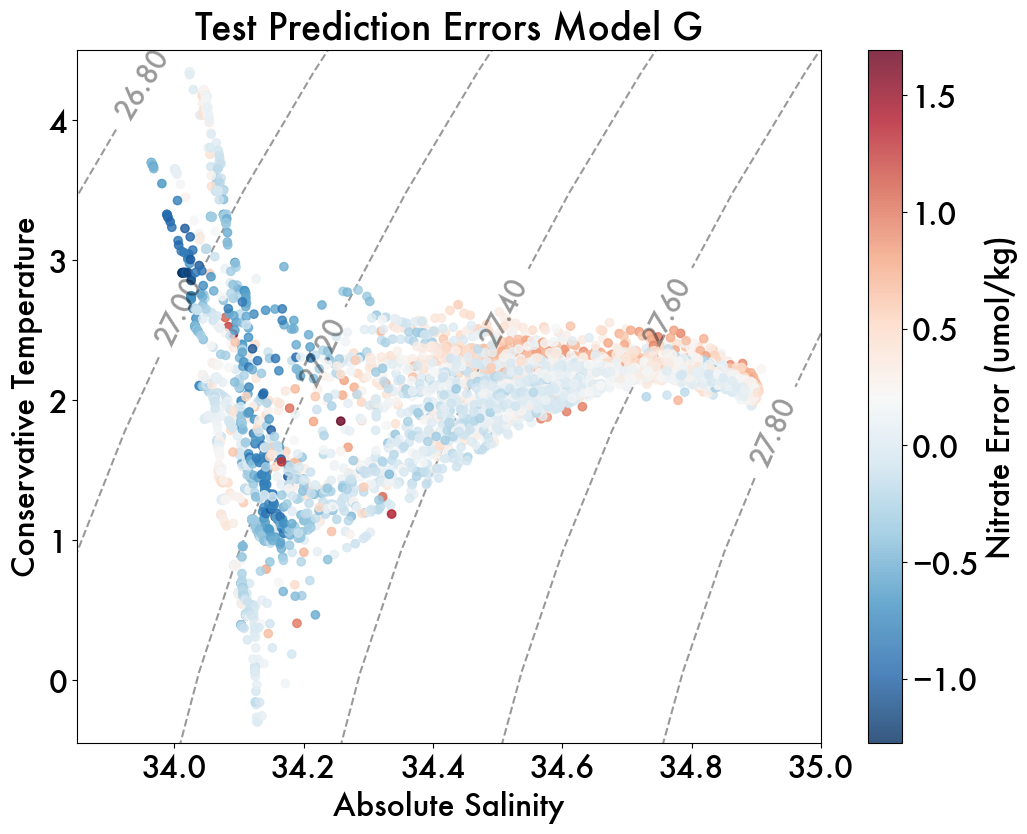

In [ ]:
# Errors in TS Space
df = RF_ver[4]['Model_G']
modtag = 'Model G'

fig = plt.figure(figsize=(12,9))
ax = fig.gca()
plt.scatter(df.SA, df.CT, c=df.test_error, cmap='RdBu_r', alpha=0.8, zorder=3)  # , vmin=-5, vmax=5
plt.colorbar().set_label('Nitrate Error (umol/kg)')
plt.show

# Add density contours
# Figure out boudaries (mins and maxs)
smin = df.SA.min() -.3
smax = df.SA.max() +.3

tmin= df.CT.min() - 1.5
tmax = df.CT.max() + 0.9

# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin

# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.sigma0(si[i],ti[j])

CS = ax.contour(si,ti,dens, linestyles='dashed', colors='k', alpha=0.4, zorder=1)
ax.clabel(CS, fontsize=20, fmt='%1.2f')
ax.set_ylim(-0.45,4.5)
ax.set_xlim(33.85, 35.0)

ax.set_xlabel('Absolute Salinity')
ax.set_ylabel('Conservative Temperature')
ax.set_title('Test Prediction Errors ' + modtag)


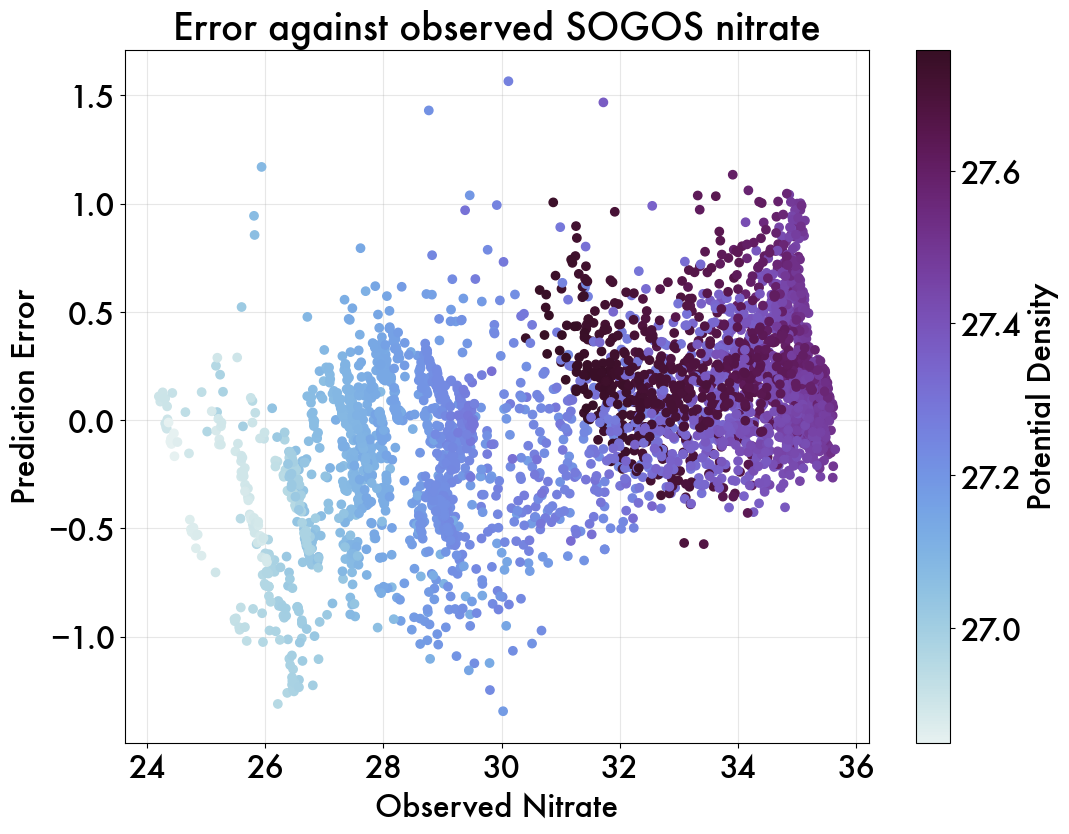

In [ ]:
# Error against observed
fig = plt.figure(figsize=(12,9))
ax = fig.gca()
plt.scatter(df.nitrate, df.test_error, c=df.sigma0, cmap=cmo.dense, zorder=3)
cbar = plt.colorbar()
cbar.set_label('Potential Density')
ax.set_xlabel('Observed Nitrate')
ax.set_ylabel('Prediction Error')
ax.set_title('Error against observed SOGOS nitrate')
ax.grid(alpha=0.3, zorder=1)


# fig = plt.figure(figsize=(12,9))
# ax = fig.gca()
# plt.scatter(df.nitrate, df.test_error, c=df.CT, cmap=cmo.thermal, zorder=3)
# cbar = plt.colorbar()
# cbar.set_label('Conservative Temperature')
# ax.set_xlabel('Observed Nitrate')
# ax.set_ylabel('Prediction Error')
# ax.set_title('Error against observed SOGOS nitrate')
# ax.grid(alpha=0.3, zorder=1)


# fig = plt.figure(figsize=(12,9))
# ax = fig.gca()
# plt.scatter(df.nitrate, df.test_error, c=df.SA, cmap=cmo.haline, zorder=3)
# cbar = plt.colorbar()
# cbar.set_label('Absolute Salinity')
# ax.set_xlabel('Observed Nitrate')
# ax.set_ylabel('Prediction Error')
# ax.set_title('Error against observed SOGOS nitrate')
# ax.grid(alpha=0.3, zorder=1)



# Comparison to ESPER/CANYON

In [ ]:
desc = 'split2023'

In [ ]:
float_6030 = test.copy()
for k in ['Model_A', 'Model_B', 'Model_C', 'Model_D', 'Model_E', 'Model_F', 'Model_G']:
    temp = RF_ver[4][k]['test_prediction'].values
    float_6030[k] = temp

float_6030['temperature'] = gsw.t_from_CT(float_6030.SA, float_6030.CT, float_6030.pressure)
float_6030['salinity'] = gsw.SP_from_SA(float_6030.SA, float_6030.pressure, float_6030.lon, float_6030.lat)

# Save for general use in RF-training
float_6030
float_6030.to_csv('../working-vars/RF-training/mlresult_wmo5906030_allpreds_' + desc + '.csv')

In [ ]:
# Save data for CANYON
float_6030.to_csv('../working-vars/CANYON-prediction/mlresult_wmo5906030_allpreds_nov2023.csv')

# Save data for ESPER
importlib.reload(dfproc)
dfproc.DF2mat(float_6030, '../working-vars/ESPER-prediction/wmo5906030_data_nov2023.mat')

Saved to ../working-vars/ESPER-prediction/wmo5906030_data_nov2023.mat


In [ ]:
# After running CANYON
dir = '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/working-vars/'
sogos_canyon = pd.read_csv(dir + 'CANYON-prediction/wmo5906030_MATLAB_canyon_pred_nov2023.csv')

for var in ['pressure', 'yearday', 'nitrate', 'Model_G']:
    sogos_canyon[var] = np.array(float_6030[var])

sogos_canyon['prediction_error'] = sogos_canyon.prediction - sogos_canyon.nitrate
sogos_canyon['pred_relative_error'] = sogos_canyon.prediction_error/sogos_canyon.nitrate

sogos_canyon.to_csv('../working-vars/CANYON-prediction/wmo5906030_df_with_canyon_nov2023.csv')

In [ ]:
# After running ESPER
sogos_esper = pd.read_csv('../working-vars/ESPER-prediction/wmo5906030_MATLAB_esper_pred_nov2023.csv')
sogos_esper

for var in ['pressure', 'yearday', 'nitrate', 'Model_G']:
    sogos_esper[var] = np.array(float_6030[var])

sogos_esper['prediction_error'] = sogos_esper.prediction - sogos_esper.nitrate
sogos_esper['rel_pred_error'] = sogos_esper.prediction_error/sogos_esper.nitrate

sogos_esper.to_csv('../working-vars/ESPER-prediction/wmo5906030_df_with_esper_nov2023.csv')

In [ ]:
print('CANYON')
# print_error_bounds(RF_ver[4]['Model_G'], var='test_relative_error')
print_error_depths(sogos_canyon, var='rel_pred_error', pres_lim = [0,250])

CANYON
Errors between depths 0 to 250:
median abs error: 	0.04858486266772183
mean abs error 		0.05131581155092247

95% of errors fall between:
-0.1027 to 0.00154

During SOGOS between depths 0 to 250:
95% of errors fall between:
-0.0909 to -0.01198


(950.0, 0.0)

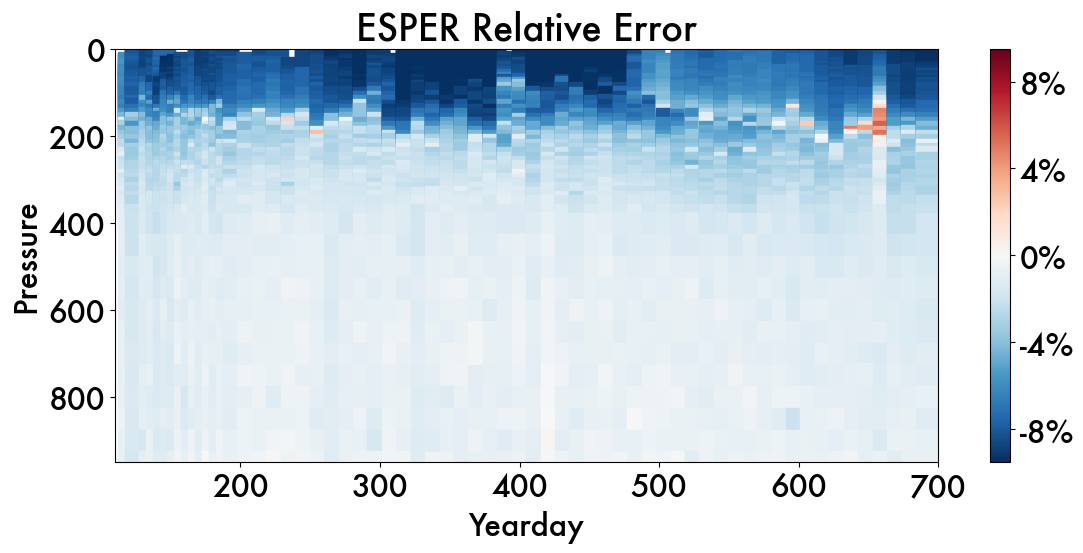

In [ ]:
# Plotting ESPER Relative Error profile maps
dat = sogos_esper

fig  = plt.figure(figsize=(12,6), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.rel_pred_error, cmap='RdBu_r', s=250, marker='s', vmin=-.095, vmax=.095) #vmin=-0.090, vmax=0.090) #, vmin=-2.5, vmax=2.5) # , , vmin = 24, vmax=35.0

ax.set_title('ESPER Relative Error')


ticklist = [-0.08, -0.04, 0, 0.04, 0.08] 
# ticklist = [-0.05, -0.025, 0, 0.025, 0.05]
cbar = plt.colorbar(sca, ax=ax, ticks=ticklist) # [-0.28, -0.025, 0, 0.025, 0.28]
# cbar.ax.set_yticklabels(['-5.0%', '-2.5%', '0%', '2.5%', '5.0%'])  # Setting tick labels here
cbar.ax.set_yticklabels(['-8%', '-4%', '0%', '4%', '8%']) 


# cbar.set_label('Relative Error') 

ax.invert_yaxis()
ax.set_ylabel('Pressure')
ax.set_xlabel('Yearday')
# ax.set_xlim([120, 550])
# ax.set_ylim([600,0])

ax.set_xlim([110,700])
ax.set_ylim([950,0])

(950.0, 0.0)

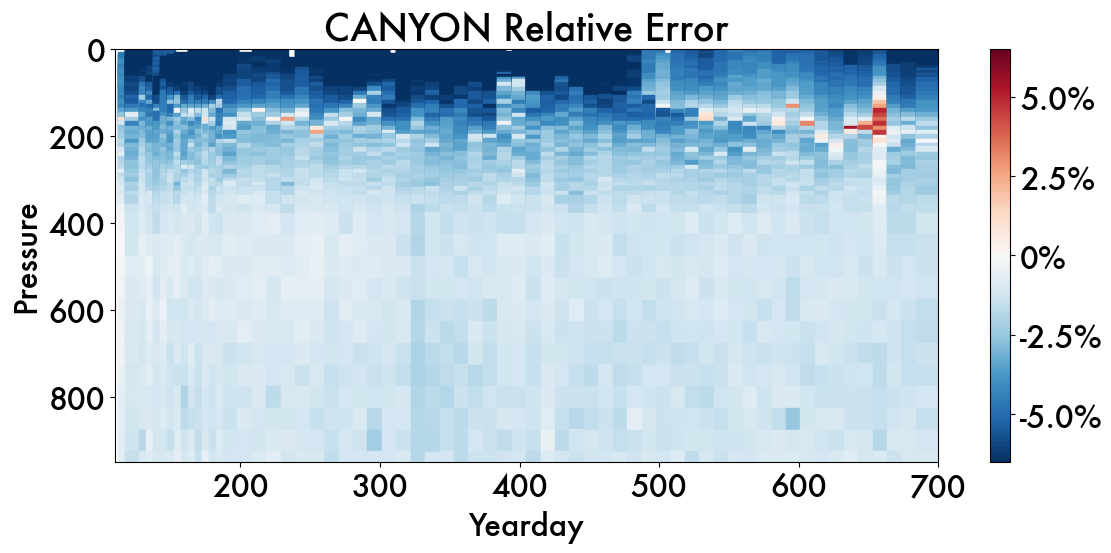

In [ ]:
# Plotting CANYON Relative Error profile maps
dat = sogos_canyon

fig  = plt.figure(figsize=(12,6), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.rel_pred_error, cmap='RdBu_r', s=250, marker='s', vmin=-.065, vmax=.065) #vmin=-0.065, vmax=0.065) #, vmin=-2.5, vmax=2.5) # , , vmin = 24, vmax=35.0

ax.set_title('CANYON Relative Error')

# ticklist = [-0.04, -0.02, 0, 0.02, 0.04] 
ticklist = [-0.05, -0.025, 0, 0.025, 0.05]
cbar = plt.colorbar(sca, ax=ax, ticks=ticklist) # [-0.28, -0.025, 0, 0.025, 0.28]
cbar.ax.set_yticklabels(['-5.0%', '-2.5%', '0%', '2.5%', '5.0%'])  # Setting tick labels here
# cbar.set_label('Relative Error') 

ax.invert_yaxis()
ax.set_ylabel('Pressure')
ax.set_xlabel('Yearday')
# ax.set_xlim([120, 550])
# ax.set_ylim([600,0])

ax.set_xlim([110,700])
ax.set_ylim([950,0])

Text(0.5, 0, 'Yearday')

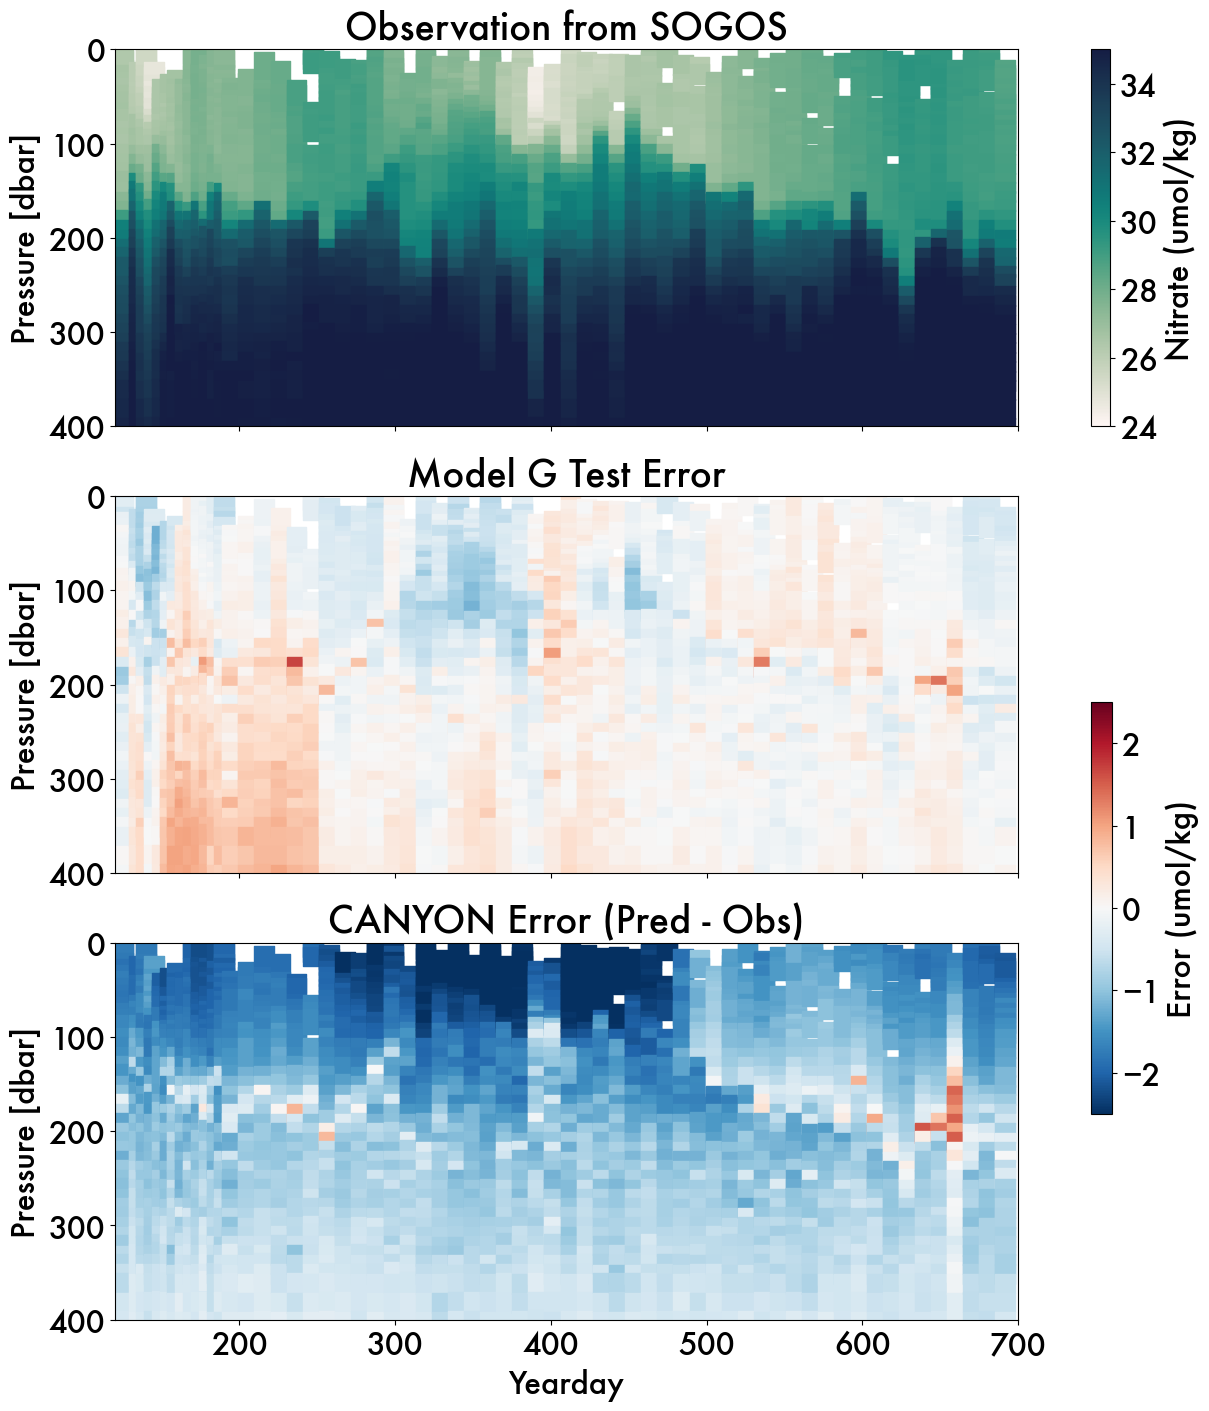

In [ ]:
# * (Absolute, 3 subplots) Prediction, Obs, and Error Profiles
dat = RF_ver[4]['Model_G']

fig, axs = plt.subplots(3,1, figsize=(12,14), layout='constrained', sharex=True)
axs = axs.flatten()

sca0 = axs[0].scatter(dat.yearday, dat.pressure, c=dat.nitrate, cmap=cmo.tempo, s=200, marker='s', vmin=24, vmax=35) #, vmin=0, vmax=0.005
axs[0].set_title('Observation from SOGOS')

sca1 = axs[1].scatter(dat.yearday, dat.pressure, c=dat.test_error, cmap='RdBu_r', s=200, marker='s',vmin=-2.5, vmax=2.5) #, vmin=0, vmax=0.005
axs[1].set_title('Model G Test Error') 

sca2 = axs[2].scatter(sogos_canyon.yearday, sogos_canyon.pressure, c=sogos_canyon.prediction_error, cmap='RdBu_r', s=200, marker='s', vmin=-2.5, vmax=2.5)
axs[2].set_title('CANYON Error (Pred - Obs)')


fig.colorbar(sca0, ax=axs[0:1]).set_label('Nitrate (umol/kg)')
# fig.colorbar(sca1, ax=axs[1]).set_label('Nitrate (umol/kg)')
fig.colorbar(sca1, ax=axs[1:], shrink=0.5).set_label('Error (umol/kg)')
# fig.colorbar(sca2, ax=axs[2], shrink=0.5).set_label('Error (umol/kg)')

for ax in axs:
    ax.invert_yaxis()
    ax.set_ylabel('Pressure [dbar]')
    ax.set_xlim([120,700])
    ax.set_ylim([400,0])


axs[2].set_xlabel('Yearday')

# plt.savefig('../figures/canyon_err.png', dpi=300, bbox_inches='tight')

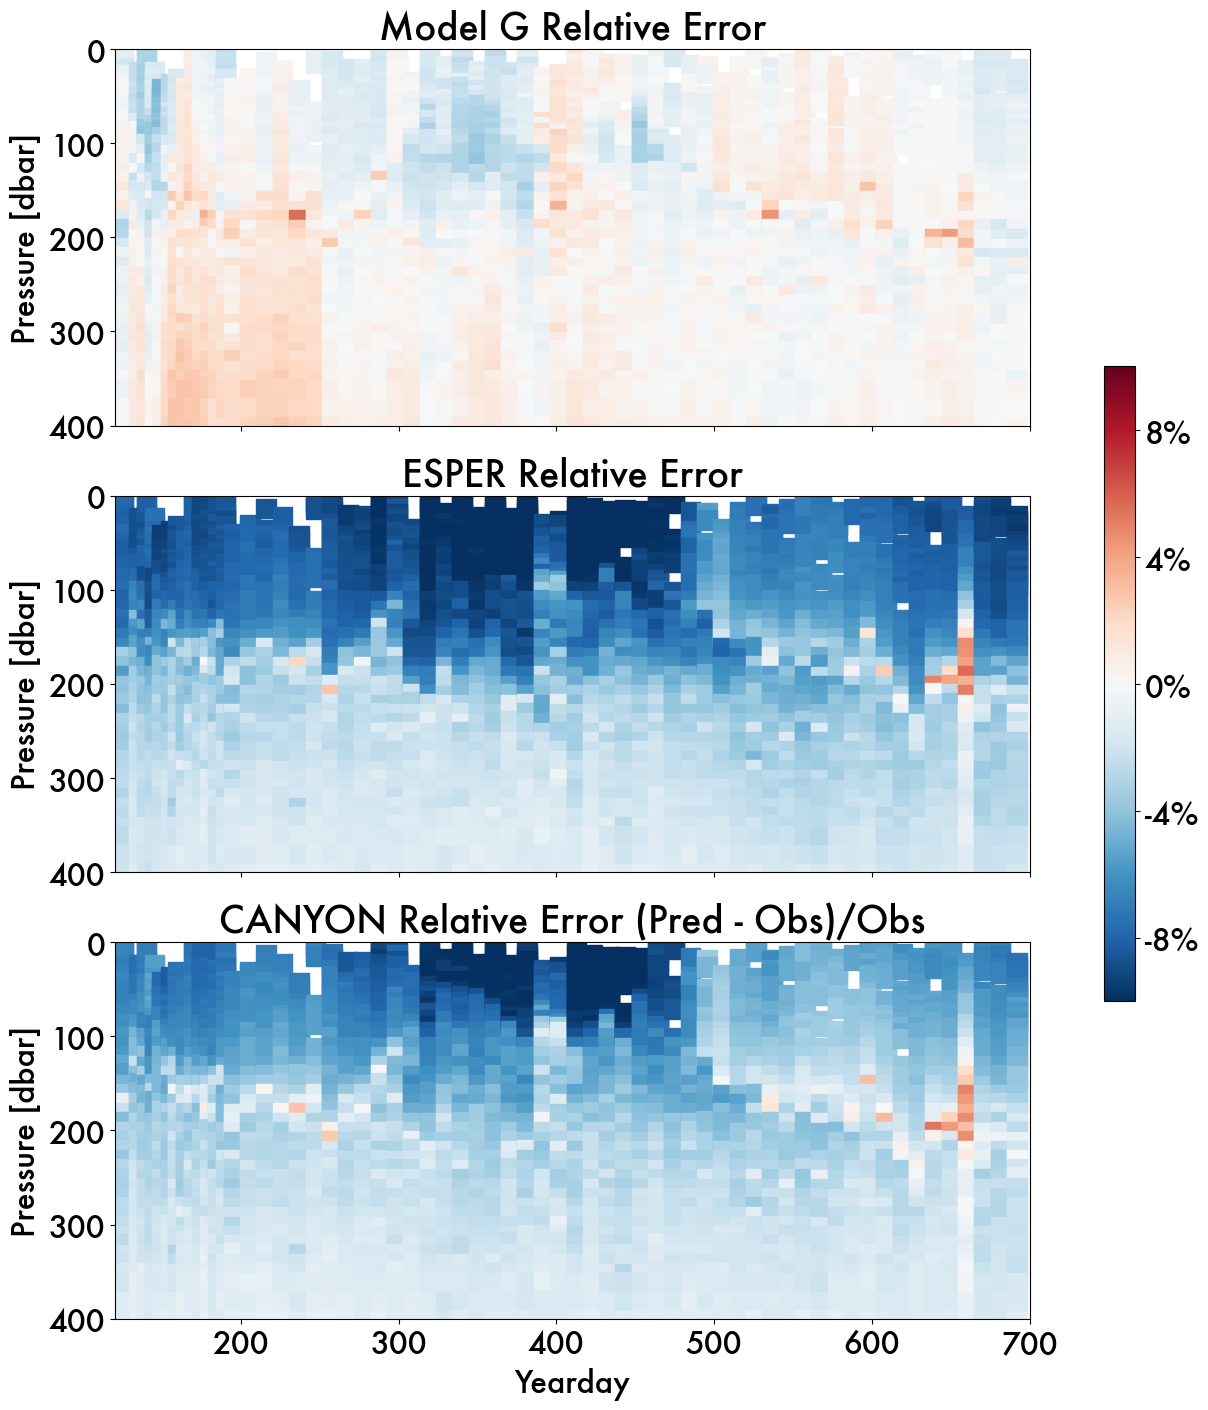

In [ ]:
# * (Absolute, 3 subplots) Prediction, Obs, and Error Profiles
# RELATIVE 
dat = RF_ver[4]['Model_G']

fig, axs = plt.subplots(3,1, figsize=(12,14), layout='constrained', sharex=True)
axs = axs.flatten()

sca0 = axs[0].scatter(dat.yearday, dat.pressure, c=dat.test_relative_error, cmap='RdBu_r', s=200, marker='s', vmin=-.10, vmax=.10) #, vmin=0, vmax=0.005
axs[0].set_title('Model G Relative Error')

sca1 = axs[1].scatter(sogos_esper.yearday, sogos_esper.pressure, c=sogos_esper.rel_pred_error, cmap='RdBu_r', s=200, marker='s',vmin=-.10, vmax=.10) #, vmin=0, vmax=0.005
axs[1].set_title('ESPER Relative Error') 

sca2 = axs[2].scatter(sogos_canyon.yearday, sogos_canyon.pressure, c=sogos_canyon.rel_pred_error, cmap='RdBu_r', s=200, marker='s', vmin=-.10, vmax=.10)
axs[2].set_title('CANYON Relative Error (Pred - Obs)/Obs')

ticklist = [-0.08, -0.04, 0, 0.04, 0.08] 
cbar = fig.colorbar(sca1, ax=axs[:], ticks=ticklist, shrink=0.5).ax.set_yticklabels(['-8%', '-4%', '0%', '4%', '8%']) 
# cbar.ax.set_yticklabels(['-8%', '-4%', '0%', '4%', '8%']) 

for ax in axs:
    ax.invert_yaxis()
    ax.set_ylabel('Pressure [dbar]')
    ax.set_xlim([120,700])
    ax.set_ylim([400,0])


axs[2].set_xlabel('Yearday')

plt.savefig('../figures/canyon_esper_rel_error_400m.png', dpi=300, bbox_inches='tight')

In [ ]:

dat_three = sogos_canyon
testerr_three = {
    "0-100": dat_three[(dat_three["pressure"] >= 0) & (dat_three["pressure"] < 100)]["prediction_error"].values,
    "100-200": dat_three[(dat_three["pressure"] >= 100) & (dat_three["pressure"] < 200)]["prediction_error"].values,
    "200-300": dat_three[(dat_three["pressure"] >= 200) & (dat_three["pressure"] < 300)]["prediction_error"].values,
    "300-400": dat_three[(dat_three["pressure"] >= 300) & (dat_three["pressure"] < 400)]["prediction_error"].values,
    "400-500": dat_three[(dat_three["pressure"] >= 400) & (dat_three["pressure"] < 500)]["prediction_error"].values,
    "500-600": dat_three[(dat_three["pressure"] >= 500) & (dat_three["pressure"] < 600)]["prediction_error"].values,
    "600-700": dat_three[(dat_three["pressure"] >= 600) & (dat_three["pressure"] < 700)]["prediction_error"].values,
    "700-800": dat_three[(dat_three["pressure"] >= 700) & (dat_three["pressure"] < 800)]["prediction_error"].values,
    "800-900": dat_three[(dat_three["pressure"] >= 800) & (dat_three["pressure"] < 900)]["prediction_error"].values,
    "900-1000": dat_three[(dat_three["pressure"] >= 900) & (dat_three["pressure"] < 1000)]["prediction_error"].values
}


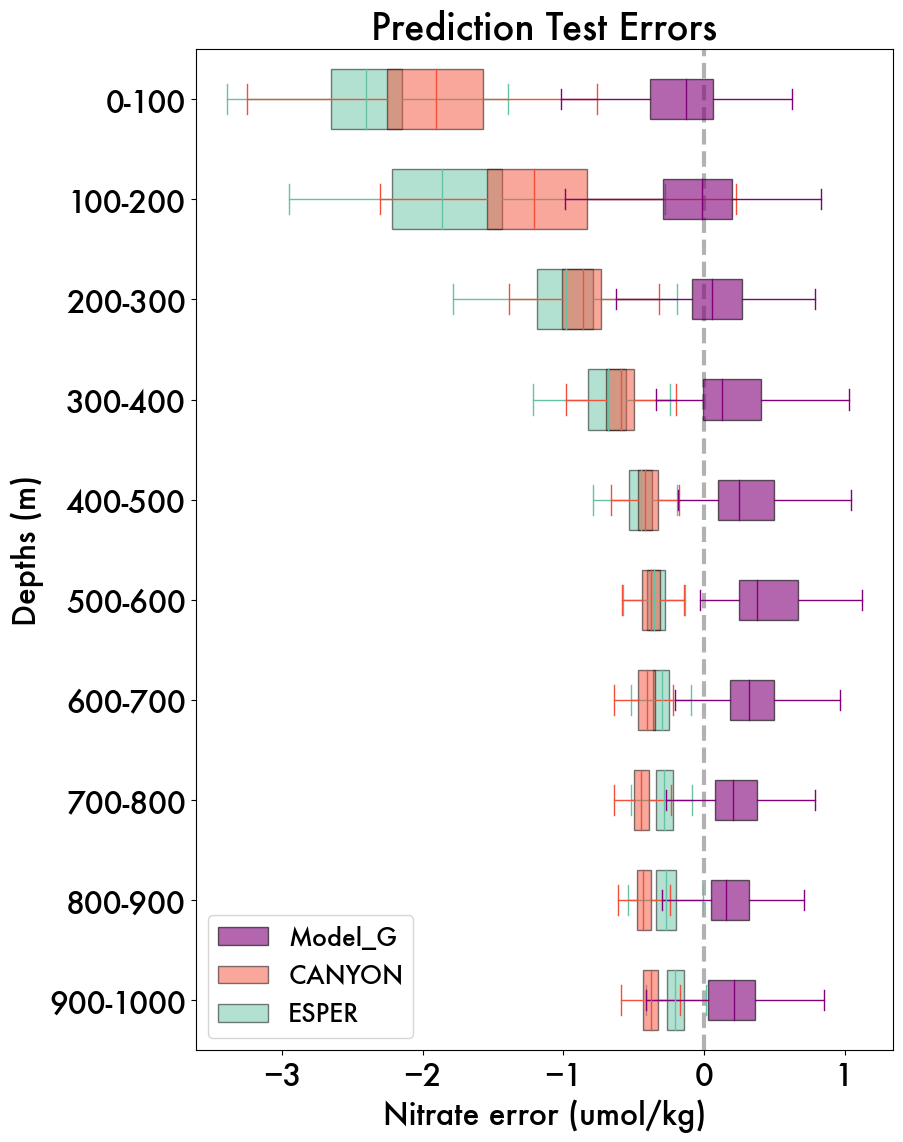

In [ ]:
# GOOD VERISON: Compare two models 


mod_one = 'Model_G'
mod_two = 'CANYON'
mod_three = 'ESPER'

dat_one = RF_ver[4][mod_one]
testerr_one = {
    "0-100": dat_one[(dat_one["pressure"] >= 0) & (dat_one["pressure"] < 100)]["test_error"].values,
    "100-200": dat_one[(dat_one["pressure"] >= 100) & (dat_one["pressure"] < 200)]["test_error"].values,
    "200-300": dat_one[(dat_one["pressure"] >= 200) & (dat_one["pressure"] < 300)]["test_error"].values,
    "300-400": dat_one[(dat_one["pressure"] >= 300) & (dat_one["pressure"] < 400)]["test_error"].values,
    "400-500": dat_one[(dat_one["pressure"] >= 400) & (dat_one["pressure"] < 500)]["test_error"].values,
    "500-600": dat_one[(dat_one["pressure"] >= 500) & (dat_one["pressure"] < 600)]["test_error"].values,
    "600-700": dat_one[(dat_one["pressure"] >= 600) & (dat_one["pressure"] < 700)]["test_error"].values,
    "700-800": dat_one[(dat_one["pressure"] >= 700) & (dat_one["pressure"] < 800)]["test_error"].values,
    "800-900": dat_one[(dat_one["pressure"] >= 800) & (dat_one["pressure"] < 900)]["test_error"].values,
    "900-1000": dat_one[(dat_one["pressure"] >= 900) & (dat_one["pressure"] < 1000)]["test_error"].values
}

dat_two = sogos_canyon
testerr_two = {
    "0-100": dat_two[(dat_two["pressure"] >= 0) & (dat_two["pressure"] < 100)]["prediction_error"].values,
    "100-200": dat_two[(dat_two["pressure"] >= 100) & (dat_two["pressure"] < 200)]["prediction_error"].values,
    "200-300": dat_two[(dat_two["pressure"] >= 200) & (dat_two["pressure"] < 300)]["prediction_error"].values,
    "300-400": dat_two[(dat_two["pressure"] >= 300) & (dat_two["pressure"] < 400)]["prediction_error"].values,
    "400-500": dat_two[(dat_two["pressure"] >= 400) & (dat_two["pressure"] < 500)]["prediction_error"].values,
    "500-600": dat_two[(dat_two["pressure"] >= 500) & (dat_two["pressure"] < 600)]["prediction_error"].values,
    "600-700": dat_two[(dat_two["pressure"] >= 600) & (dat_two["pressure"] < 700)]["prediction_error"].values,
    "700-800": dat_two[(dat_two["pressure"] >= 700) & (dat_two["pressure"] < 800)]["prediction_error"].values,
    "800-900": dat_two[(dat_two["pressure"] >= 800) & (dat_two["pressure"] < 900)]["prediction_error"].values,
    "900-1000": dat_two[(dat_two["pressure"] >= 900) & (dat_two["pressure"] < 1000)]["prediction_error"].values
}


dat_three = sogos_esper
testerr_three = {
    "0-100": dat_three[(dat_three["pressure"] >= 0) & (dat_three["pressure"] < 100)]["prediction_error"].values,
    "100-200": dat_three[(dat_three["pressure"] >= 100) & (dat_three["pressure"] < 200)]["prediction_error"].values,
    "200-300": dat_three[(dat_three["pressure"] >= 200) & (dat_three["pressure"] < 300)]["prediction_error"].values,
    "300-400": dat_three[(dat_three["pressure"] >= 300) & (dat_three["pressure"] < 400)]["prediction_error"].values,
    "400-500": dat_three[(dat_three["pressure"] >= 400) & (dat_three["pressure"] < 500)]["prediction_error"].values,
    "500-600": dat_three[(dat_three["pressure"] >= 500) & (dat_three["pressure"] < 600)]["prediction_error"].values,
    "600-700": dat_three[(dat_three["pressure"] >= 600) & (dat_three["pressure"] < 700)]["prediction_error"].values,
    "700-800": dat_three[(dat_three["pressure"] >= 700) & (dat_three["pressure"] < 800)]["prediction_error"].values,
    "800-900": dat_three[(dat_three["pressure"] >= 800) & (dat_three["pressure"] < 900)]["prediction_error"].values,
    "900-1000": dat_three[(dat_three["pressure"] >= 900) & (dat_three["pressure"] < 1000)]["prediction_error"].values
}



color_one = model_palettes['Model_G'] # sns.color_palette("Purples")[3]
color_two = model_palettes['Model_D']
color_three = model_palettes['Model_A']

# col_one = {'color':color_one, 'linewidth':1}
col_one = {'color':color_one, 'linewidth':1}
col_two = {'color':color_two, 'linewidth':1}
col_three = {'color':color_three, 'linewidth':1}

fig = plt.figure(figsize=(9,13))
# fig = plt.figure(figsize=(13,13))
ax = fig.gca()


bplot_three = ax.boxplot(testerr_three.values(), vert=False, showfliers=False, widths=0.6, 
                    patch_artist=True, boxprops={'facecolor':color_three, 'alpha':0.5, 'edgecolor':'k'},
                    medianprops= col_three,
                    capprops=col_three,
                    whiskerprops=col_three,
                    flierprops=col_three)

bplot_two = ax.boxplot(testerr_two.values(), vert=False, showfliers=False, widths=0.6, 
                    patch_artist=True, boxprops={'facecolor':color_two, 'alpha':0.5, 'edgecolor':'k'},
                    medianprops= col_two,
                    capprops=col_two,
                    whiskerprops=col_two,
                    flierprops=col_two)

bplot_one = ax.boxplot(testerr_one.values(), vert=False, showfliers=False, widths=0.4, 
                    patch_artist=True, boxprops={'facecolor':color_one, 'alpha':0.6},
                    medianprops=col_one,
                    capprops=col_one,
                    whiskerprops=col_one,
                    flierprops=col_one)


# bplot_two = ax.boxplot(testerr_two.values(), vert=False, showfliers=False, widths=0.5, 
#                     patch_artist=True, boxprops={'facecolor':'m', 'alpha':0.5, 'edgecolor':'k'},
#                     medianprops= col_two,
#                     capprops=col_two,
#                     whiskerprops=col_two,
#                     flierprops=col_two)


ax.invert_yaxis()
ax.axvline(x=0, color='k', linestyle='--', linewidth=3, alpha=0.3, zorder=0)

labels = testerr_one.keys()
plt.yticks(range(1, len(labels) + 1), labels)
plt.ylabel("Depths (m)")
plt.xlabel("Nitrate error (umol/kg)")
plt.title("Prediction Test Errors")

ax.legend([bplot_one["boxes"][0], bplot_two["boxes"][0], bplot_three["boxes"][0]], [mod_one, mod_two, mod_three], loc='lower left', fontsize=18)

plt.savefig('../figures/canyon_esper_comparison_bydepth.png', dpi=300, bbox_inches='tight')

# 8.0 GLIDER PREDICTION


## 8.0 Basic glider statistics

## 8.1 Prediction

In [ ]:
file_path = '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/working-vars/glider/'
df_659 = pd.read_csv(file_path + 'df_659_tsO2corr_1101.csv')
df_660 = pd.read_csv(file_path + 'df_660_tsO2corr_1101.csv')

df_659 = df_659.replace(-np.inf, np.nan)
df_659 = df_659.replace(np.inf, np.nan)

df_660 = df_660.replace(-np.inf, np.nan)
df_660 = df_660.replace(np.inf, np.nan)

In [ ]:
print('Glider 660:')
sg.print_horizontal_res(df_660)

print('\nSOGOS Float: ')
sg.print_horizontal_res(test)

# sg.print_profile_nobs(df_660)
# sg.print_vertical_res(df_660)

Glider 660:
Average horizontal distance between surfacing (km): 	1.6878626294276706

SOGOS Float: 
Average horizontal distance between surfacing (km): 	70.6397521599474


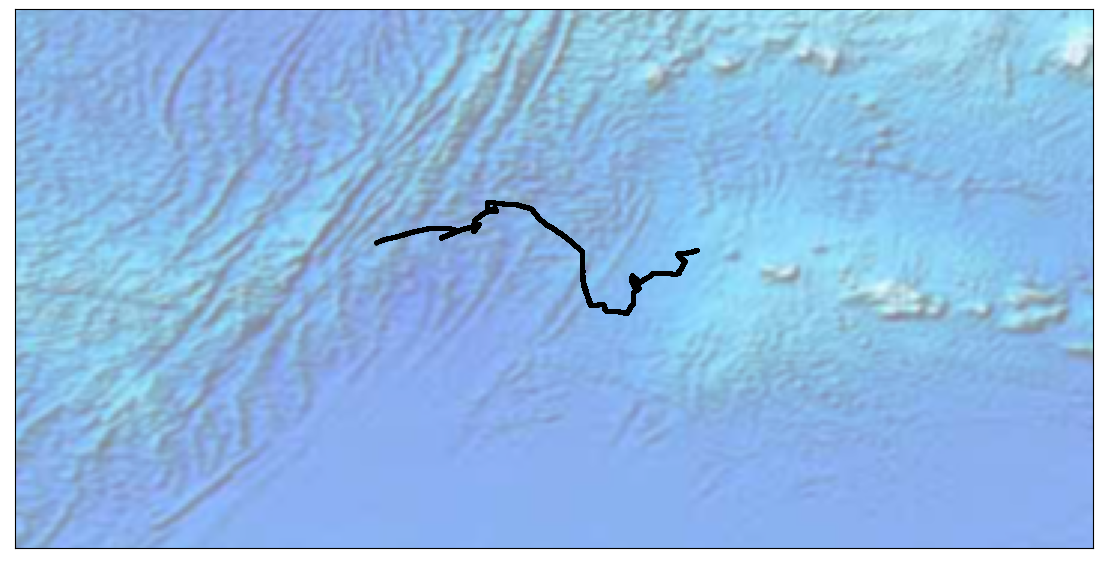

In [ ]:
fig = plt.figure(figsize=(14, 7), edgecolor='w')
m = Basemap(projection='cyl', resolution='h',
            llcrnrlat=-60, urcrnrlat=-45,
            llcrnrlon=20, urcrnrlon=50)


m.etopo(scale=0.8, alpha=0.5)

df=df_659
tag= '659'
lon = df.lon.values
lat = df.lat.values
xpt, ypt=m(lon,lat)

# m.plot(xpt, ypt, color = 'k', alpha=0.1, linewidth=2, label=tag, zorder=3)
m.scatter(xpt, ypt , color = 'k', alpha=0.1, s=3, zorder=3)

plt.show()

In [ ]:
df_659['wmoid'] = np.tile(np.nan, df_659.shape[0])
df_660['wmoid'] = np.tile(np.nan, df_660.shape[0])

In [ ]:
def add_yd_sinusoids(DF):
    DF['ydcos'] = [sg.get_ydsines(x)[0] for x in DF.yearday.values]
    DF['ydsin'] = [sg.get_ydsines(x)[1] for x in DF.yearday.values]

    return DF

df_659 = add_yd_sinusoids(df_659)
df_660 = add_yd_sinusoids(df_660)

In [ ]:
# dav_659 = dfproc.make_diveav(df_659, mld_lim=[5,20]); print() 
# dav_660 = dfproc.make_diveav(df_660, mld_lim=[5,20])
# OBSOLETE!
# FIND DAV GLIDER CALCULATION IN sogos_mixedlayer_analysis.ipynb

number of profiles with no 10m data:  38
approx # of obs within profile that were averaged for final mlp:  4.279176201372998
number of nan mlds even where 10m exists:  77

number of profiles with no 10m data:  29
approx # of obs within profile that were averaged for final mlp:  5.404102564102564
number of nan mlds even where 10m exists:  71


In [ ]:
df_659 = df_659[tvars+['profid', 'wmoid', 'bbp470', 'bbp700', 'bbp695']]
cols_na = [col for col in df_659.columns if col not in ['profid', 'wmoid', 'bbp470', 'bbp700', 'bbp695']]
df_659 = df_659.dropna(axis=0, subset=cols_na)

In [ ]:
df_660 = df_660[tvars+['profid', 'wmoid', 'bbp470', 'bbp700', 'bbp695']]
cols_na = [col for col in df_660.columns if col not in ['profid', 'wmoid', 'bbp470', 'bbp700', 'bbp695']]
df_660 = df_660.dropna(axis=0, subset=cols_na)

In [ ]:
# Method predict glider
def predict_glider(platDF, Mdl, var_list, var_predict='nitrate', type='StandardScaler'):

    platDF = platDF[tvars+['profid', 'wmoid']]
    cols_na = [col for col in platDF.columns if col not in ['profid', 'wmoid']]
    platDF_nona = platDF.dropna(axis=0, subset=cols_na) 

    platDF_scaled = scale_features(platDF_nona, training, type=type)

    X_plat= platDF_scaled[var_list].to_numpy()
    Y_plat = Mdl.predict(X_plat)

    # changed nov 2023, do not scale target

    # Currently scales back to *TRAINING* range. 
    # Note that RF model is trained on training data scaled standard. 
    # It spits out a number that is rescaled according to the training nitrate value.

    # Y_pred = rescale_target(Y_plat, training[var_predict], type='StandardScaler')


    return Y_plat


In [ ]:
# not method version

# platDF = df_659
# Mdl = aou_standard[0]['Mdl_26t']
# var_list_mdl = var_list['Mdl_26t']


# cols_na = [col for col in platDF.columns if col not in ['profid']]
# platDF_nona = platDF.dropna(axis=0, subset=cols_na) 

# platDF_scaled = scale_features(platDF, type='StandardScaler')

# X_plat= platDF_scaled[var_list_mdl].to_numpy()
# Y_plat = Mdl.predict(X_plat)

# # Currently scales back to *TRAINING* range. 
# # Note that RF model is trained on training data scaled standard. 
# # It spits out a number that is rescaled according to the training nitrate value.

# orig = np.array(training[var_predict]).reshape(-1,1) # note
# scaled = np.array(Y_plat).reshape(-1,1)
# scaler = preprocessing.StandardScaler().fit(orig)
# temp = scaler.inverse_transform(scaled)
# df_659['nitrate_26t_training'] = temp

In [ ]:
df_660['nitrate_G'] = predict_glider(df_660, RF_ver[0]['Model_G'], var_list['Model_G'])
df_659['nitrate_G'] = predict_glider(df_659, RF_ver[0]['Model_G'], var_list['Model_G'])

In [ ]:
df_660

yearday      lat      lon  pressure        CT         SA  \
4       119.510598 -51.4952  30.0253     8.070  3.646773  33.958220   
5       119.510656 -51.4952  30.0253     9.079  3.631773  33.962220   
6       119.510714 -51.4952  30.0254    10.088  3.612773  33.967220   
7       119.510772 -51.4951  30.0254    11.097  3.615773  33.965220   
8       119.510830 -51.4951  30.0254    12.106  3.612773  33.969220   
...            ...      ...      ...       ...       ...        ...   
947960  205.873787 -51.5287  39.0112   965.631  2.114773  34.873222   
947961  205.873700 -51.5287  39.0112   966.645  2.114773  34.874220   
947963  205.873498 -51.5287  39.0112   968.672  2.114773  34.874220   
947964  205.873382 -51.5287  39.0112   969.685  2.114773  34.875220   
947966  205.873179 -51.5288  39.0111   971.712  2.114773  34.875220   

            oxygen     sigma0  log_buoyancy     spice       o2sat     ydcos  \
4       327.518402  27.012310    -10.656217 -0.411330  320.416311 -0.467521   
5       327.685360  27.016935     -9.863941 -0.410118  320.523201 -0.467521   
6       327.686533  27.022739    -10.883128 -0.408624  320.658855 -0.467522   
7       327.512713  27.020866    -11.794115 -0.409716  320.640409 -0.467523   
8       327.396822  27.024322    -10.664905 -0.407211  320.653843 -0.467524   
...            ...        ...           ...       ...         ...       ...   
947960  182.046058  27.875646    -12.497102  0.081283  330.396795 -0.920139   
947961  182.106957  27.876441    -12.497102  0.081985  330.394220 -0.920140   
947963  182.209926  27.876441    -12.494619  0.081985  330.394226 -0.920141   
947964  182.221260  27.877237    -12.494619  0.082687  330.391651 -0.920142   
947966  182.271982  27.877237    -12.497164  0.082687  330.391657 -0.920143   

           ydsin   profid  wmoid    bbp470    bbp700  bbp695  nitrate_G  
4       0.883982  6600000    NaN  0.000454  0.000227  0.2074  23.919690  
5       0.883982  6600000    NaN  0.000501  0.000227  0.2074  24.181128  
6       0.883981  6600000    NaN  0.000471  0.000233  0.2379  24.204558  
7       0.883981  6600000    NaN  0.000501  0.000240  0.2684  24.199632  
8       0.883980  6600000    NaN  0.000489  0.000223  0.3294  24.196119  
...          ...      ...    ...       ...       ...     ...        ...  
947960 -0.391592  6601013    NaN       NaN       NaN     NaN  32.267929  
947961 -0.391591  6601013    NaN       NaN       NaN     NaN  32.267104  
947963 -0.391587  6601013    NaN       NaN       NaN     NaN  32.268215  
947964 -0.391586  6601013    NaN       NaN       NaN     NaN  32.237623  
947966 -0.391582  6601013    NaN       NaN       NaN     NaN  32.235879  

[737007 rows x 19 columns]

In [ ]:
file_path = '../working-vars/nitrate-prediction/'
df_659.to_csv(file_path + 'RFpred_659_modG_' + desc + '.csv')
df_660.to_csv(file_path + 'RFpred_660_modG_' + desc + '.csv')

## Overlay original float data with prediction. 

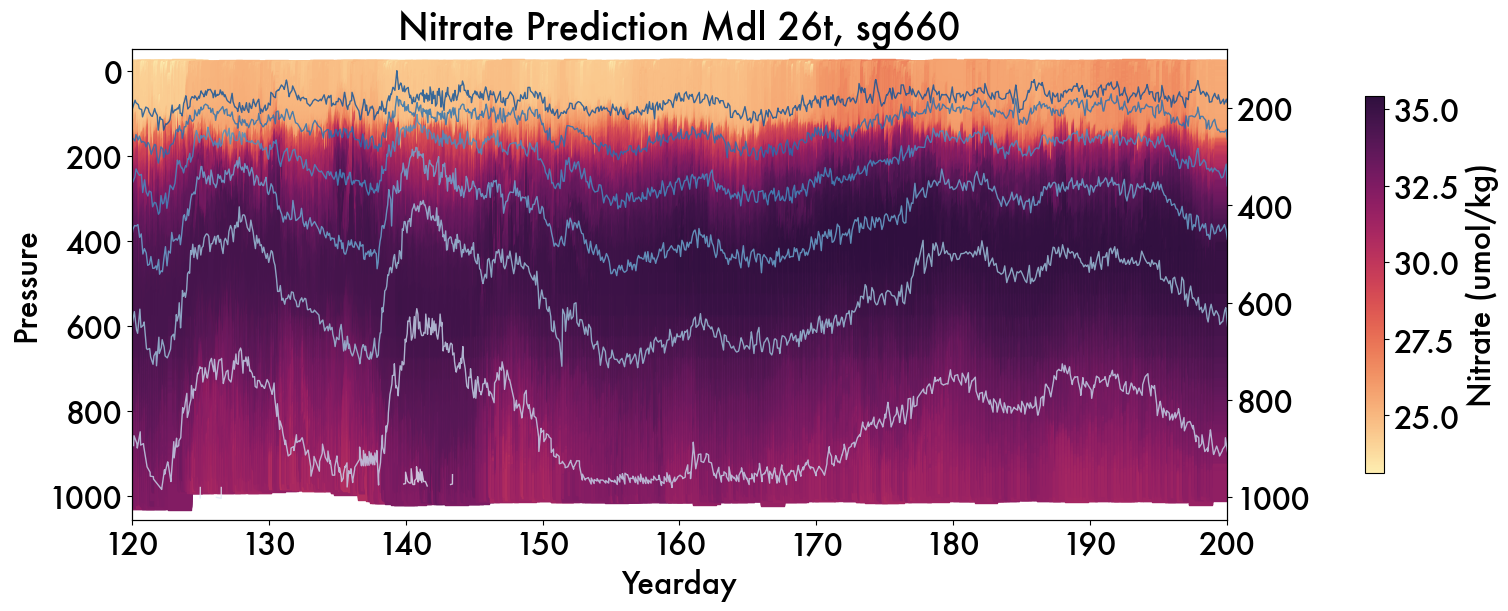

In [ ]:
# Plot density with density contours
# iso_dict = isoline_660.pop('27.2')
iso_dict = isoline_659
minday = 120
maxday = 200
df = df_660[(df_660.yearday <maxday) & (df_660.yearday > minday)]
tag = 'Mdl 26t, sg660'


# Create the scatter plot
fig, ax1 = plt.subplots(figsize=(15,6), layout='constrained')
sca = ax1.scatter(df['yearday'], df.pressure, c=df.nitrate_26t, cmap=cmo.matter, s=270, marker='s') #, vmin = 22.5, vmax=35.0)
ax1.set_ylabel('Pressure')

fig.colorbar(sca, ax=ax1, shrink=0.8).set_label('Nitrate (umol/kg)')

ax2 = ax1.twinx()
for ind, (key, val) in enumerate(iso_dict.items()):
    # Skipping lines for dates

    # Sort the DataFrame by 'yearday' to ensure the data points are in order
    val = val.sort_values(by = 'yearday')
    xval = []; yval = []

    # Iterate over the DataFrame and build the x and y values with NaN separators
    for i in range(len(val) - 1):
        xval.append(val.iloc[i]['yearday'])
        yval.append(val.iloc[i]['pressure'])
        if val.iloc[i + 1]['yearday'] - val.iloc[i]['yearday'] > 1:
            xval.append(None)
            yval.append(None)

    # Add the last data point
    xval.append(val.iloc[-1]['yearday'])
    yval.append(val.iloc[-1]['pressure'])

    ax2.plot(xval, yval, linewidth=1, label=key, color=palette[ind], alpha=0.8)

# ax2.legend(fontsize=14)
# labelLines(ax2.get_lines(), align=False, fontsize=18)
for ax in [ax1, ax2]:
    ax.invert_yaxis()
    ax.set_xlim([minday, maxday])

ax1.set_xlabel('Yearday')
plt.title('Nitrate Prediction ' + tag)

# ax1.axvline(x=187, color='c', linestyle='--', linewidth=1, alpha=0.9, zorder=3)
# ax1.axvline(x=194, color='c', linestyle='--', linewidth=1, alpha=0.9, zorder=3)
# Display the plot
plt.show()


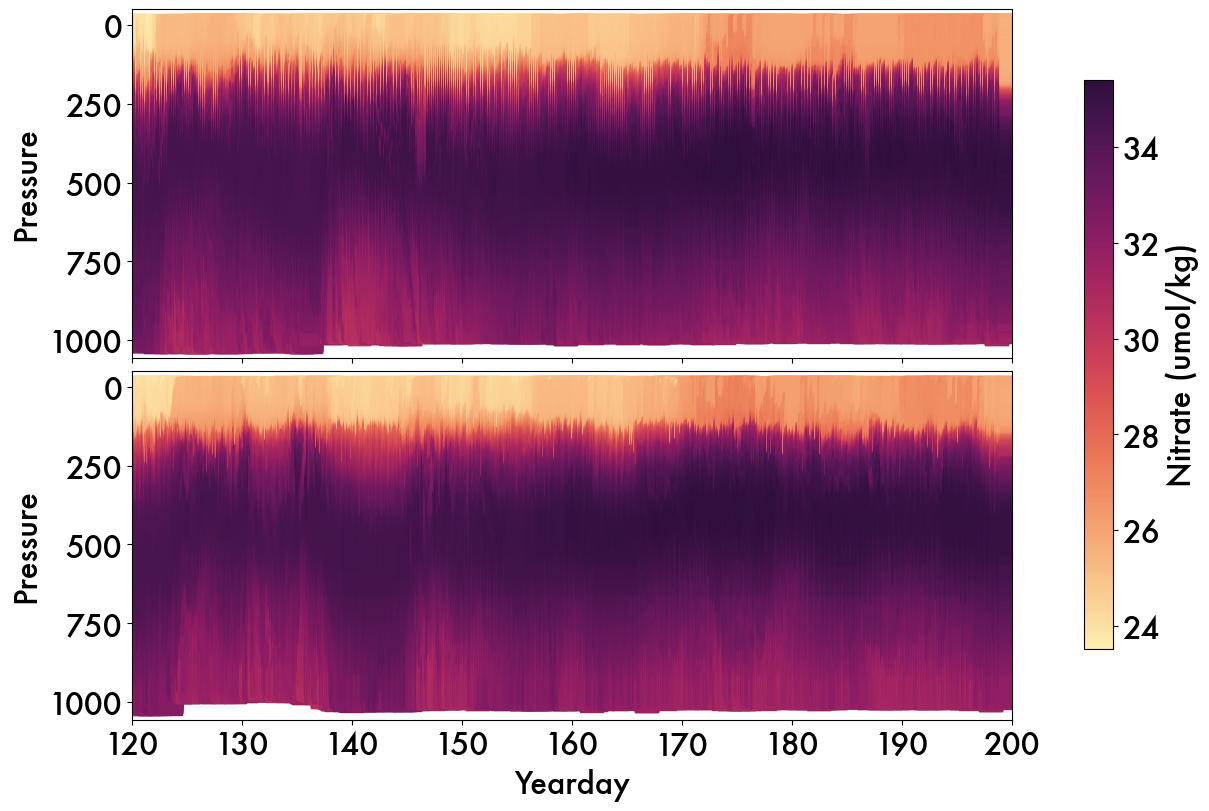

In [ ]:
# Plot density with density contours
iso_dict = isoline_660
minday = 120
maxday = 200
dat_660 = df_660[(df_660.yearday <maxday) & (df_660.yearday > minday)]
dat_659 = df_659[(df_659.yearday <maxday) & (df_659.yearday > minday)]
tag = 'Mdl 28t, sg660'


# Create the scatter plot
fig, axs = plt.subplots(2, 1, figsize=(12,8), sharex=True, layout='constrained')
axs = axs.flatten()

sca0 = axs[0].scatter(dat_659['yearday'], dat_659.pressure, c=dat_659.nitrate_28t, cmap=cmo.matter, s=270, marker='s') #, vmin = 22.5, vmax=35.0)
sca1 = axs[1].scatter(dat_660['yearday'], dat_660.pressure, c=dat_660.nitrate_28t, cmap=cmo.matter, s=270, marker='s') #, vmin = 22.5, vmax=35.0)

ax.set_ylabel('Pressure')
 
fig.colorbar(sca0, ax=axs[:], shrink=0.8).set_label('Nitrate (umol/kg)')

for ax in axs:
    ax.invert_yaxis()
    ax.set_xlim([minday, maxday])
    ax.set_ylabel('Pressure')

axs[1].set_xlabel('Yearday')
# plt.title('Nitrate Prediction ' + tag)

# Display the plot
plt.show()

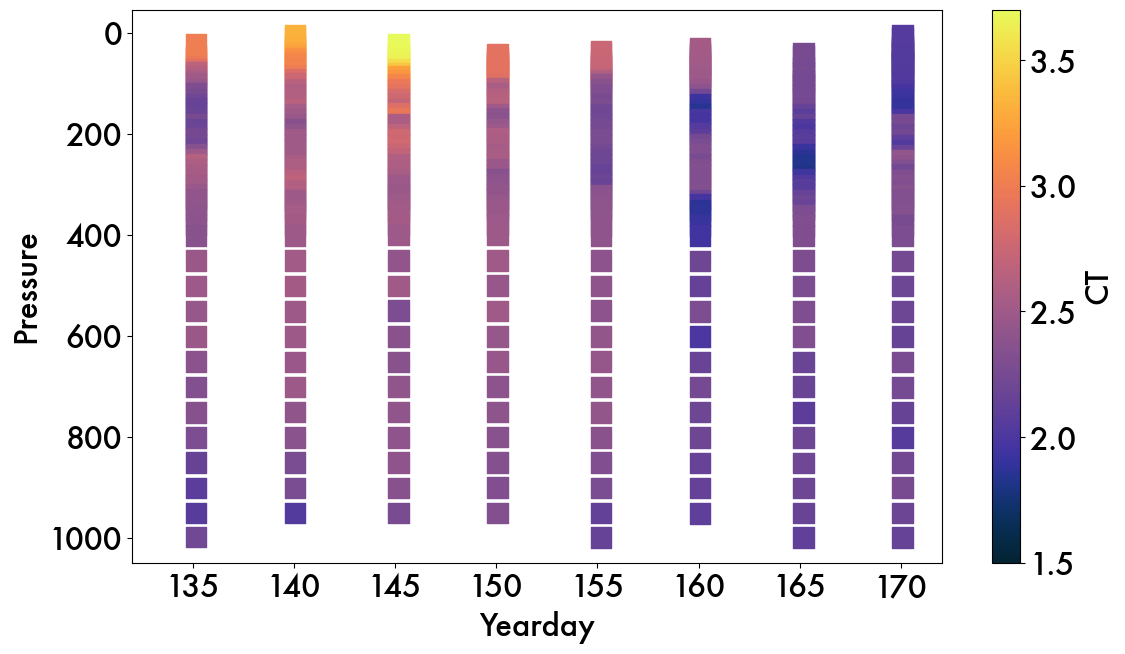

(800.0, 0.0)

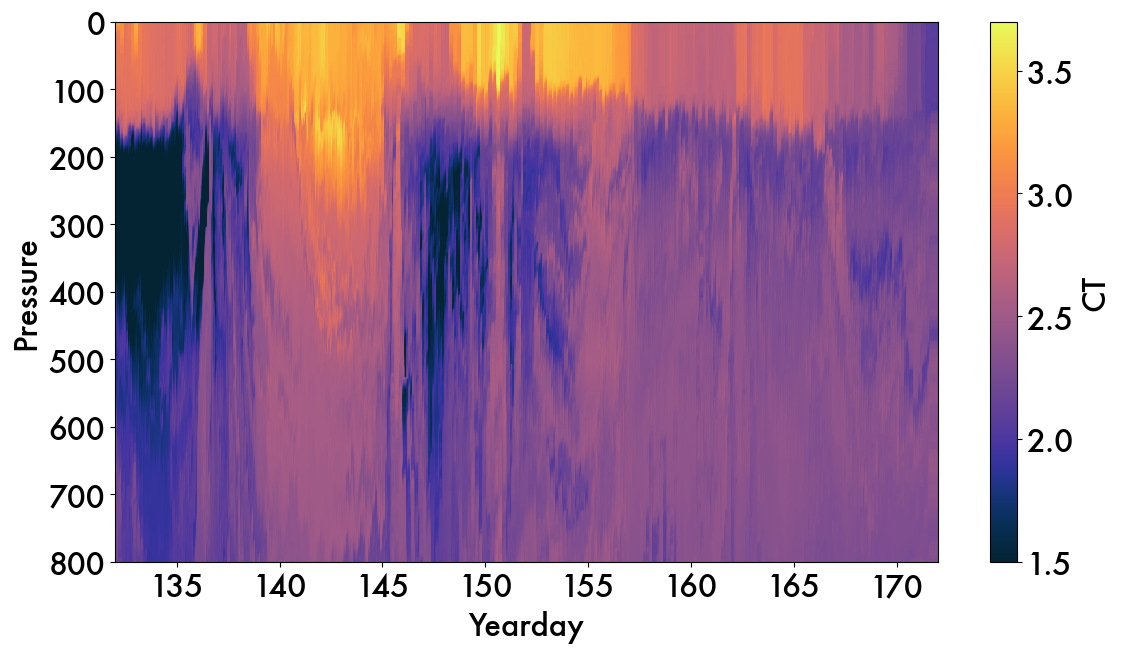

In [ ]:
# Float with glider
minday = 132
maxday = 172

# First plot float data
dat = test[(test.yearday <maxday) & (test.yearday > minday)]

fig  = plt.figure(figsize=(12,7), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.CT, cmap=cmo.thermal, s=220, marker='s', vmin=1.5, vmax=3.7) #, marker='s')
# ax.set_title('Float CT')

# ticklist = [1.5, 2.0, 2.5, 3.0, 3.5]
cbar = plt.colorbar(sca, ax=ax, ticks=ticklist).set_label('CT')
# cbar.set_yticklabels([1.5, 2.0, 2.5, 3.0, 3.5])

# plt.style.use("dark_background")

ax.invert_yaxis()
ax.set_ylabel('Pressure')
ax.set_xlabel('Yearday')
ax.set_xlim([minday, maxday])
plt.show()

######################
# Plot Glider

dat = df_660[(df_660.yearday <maxday) & (df_660.yearday > minday)]
# tag = '26t, glider 659'

fig  = plt.figure(figsize=(12,7), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.CT, cmap=cmo.thermal, s=100, marker='s', vmin=1.5, vmax=3.7)
# ax.set_title('Model ' + tag )

plt.colorbar(sca, ax=ax).set_label('CT')

ax.invert_yaxis()
ax.set_ylabel('Pressure')
ax.set_xlabel('Yearday')
ax.set_xlim([minday, maxday])
ax.set_ylim([800,0])





(800.0, 0.0)

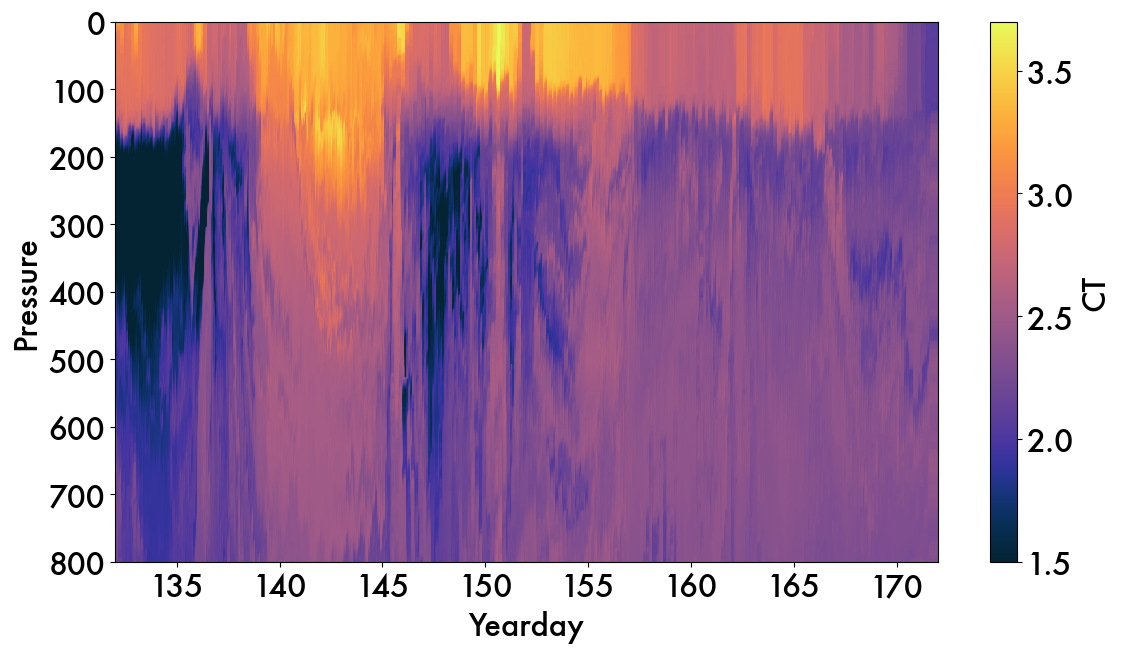

In [ ]:
# * Glider CT profile
minday = 132
maxday = 172

dat = df_660[(df_660.yearday <maxday) & (df_660.yearday > minday)]
# tag = '26t, glider 659'

fig  = plt.figure(figsize=(12,7), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.CT, cmap=cmo.thermal, s=100, marker='s', vmin=1.5, vmax=3.7)
# ax.set_title('Model ' + tag )

plt.colorbar(sca, ax=ax).set_label('CT')

ax.invert_yaxis()
ax.set_ylabel('Pressure')
ax.set_xlabel('Yearday')
ax.set_xlim([minday, maxday])
ax.set_ylim([800,0])

(800.0, 0.0)

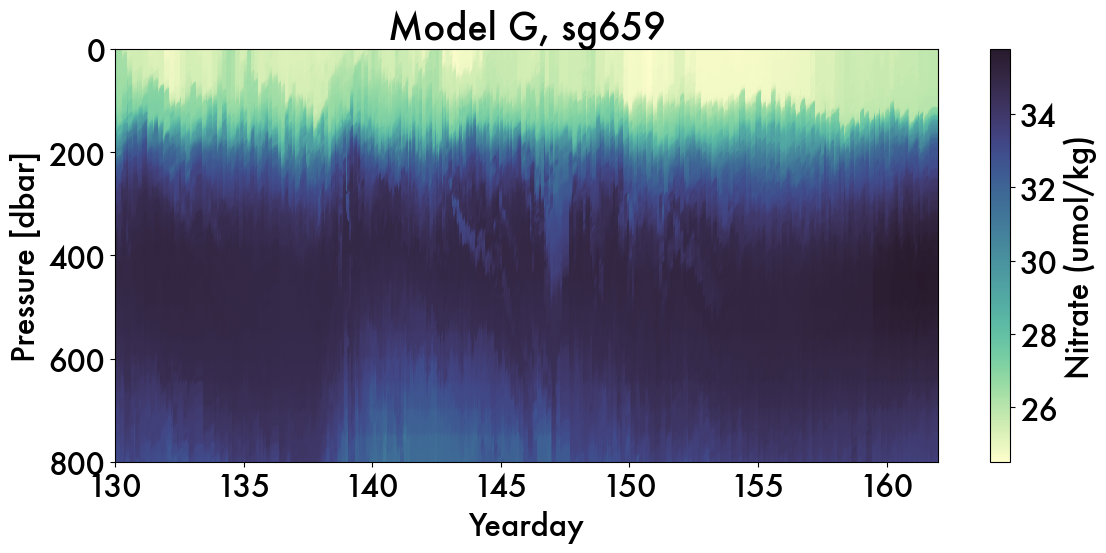

In [ ]:
# * Glider prediction nitrate profile
minday = 130
maxday = 162

dat = df_659[(df_659.yearday <maxday) & (df_659.yearday > minday)]
tag = 'Model G, sg659'


fig  = plt.figure(figsize=(12,6), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.nitrate_G, cmap=cmo.deep, s=50) #, vmin=1.5, vmax=3.6) #, marker='s')
ax.set_title(tag )

plt.colorbar(sca, ax=ax).set_label('Nitrate (umol/kg)')

ax.invert_yaxis()
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')
ax.set_xlim([minday, maxday])
ax.set_ylim([800,0])


# Glider ML Statistics

In [ ]:
len(sg.list_profile_DFs(df_659))

912

In [ ]:
importlib.reload(dfproc)

<module 'sgmod_DFproc' from '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/scripts/sgmod_DFproc.py'>

In [ ]:
dav_659 = dfproc.make_diveav(df_659) # from 7 to 13

number of profiles with no 10m data:  59
approx # of obs within profile that were averaged for final mlp:  1.9273153575615474


In [ ]:
dav_659 = dfproc.make_diveav(df_659) # from 5 to 15 dbar

number of profiles with no 10m data:  41
approx # of obs within profile that were averaged for final mlp:  1.9380022962112515


In [ ]:
dav_660 = dfproc.make_diveav(df_660)

number of profiles with no 10m data:  81
approx # of obs within profile that were averaged for final mlp:  2.1917659804983747


In [ ]:
# Make new dataframe that is only the upper DF in the mixed layer 

# now in dfproc
# mldf_659 = pd.DataFrame()

# for i, prof in enumerate(dfproc.list_profile_DFs(df_659)):
#     mlp = dav_659.mld[i]
#     if mlp != np.nan:
#         upperprof = prof[prof.pressure<mlp].copy()

#         mlp_array = np.tile(mlp, upperprof.shape[0])
#         upperprof['mld'] = mlp_array
#         mldf_659 = pd.concat([mldf_659, upperprof], ignore_index=True)

mldf_659 = dfproc.make_mldf(df_659, dav_659)

yearday      lat      lon  pressure        CT         SA  \
0      119.616270 -51.4817  30.0739     4.035  3.565758  33.985030   
1      119.616328 -51.4817  30.0739     5.044  3.565758  33.986034   
2      119.616357 -51.4817  30.0739     6.053  3.565758  33.986034   
3      119.616385 -51.4817  30.0740     7.062  3.564758  33.986034   
4      119.616414 -51.4817  30.0740     8.070  3.563758  33.987034   
...           ...      ...      ...       ...       ...        ...   
46593  206.065014 -51.7020  38.9939   139.262  1.799758  34.098034   
46594  206.064898 -51.7020  38.9939   140.271  1.796758  34.101032   
46595  206.064782 -51.7021  38.9939   141.280  1.797758  34.102030   
46596  206.064667 -51.7021  38.9939   142.290  1.796758  34.106033   
46597  206.064580 -51.7021  38.9939   143.299  1.791758  34.109030   

           oxygen     sigma0  log_buoyancy     spice  ...     mncos     mnsin  \
0      330.053918  26.900568    -12.977491 -0.534645  ... -0.500000  0.866025   
1      330.290852  26.901363    -12.977491 -0.533936  ... -0.500000  0.866025   
2      330.425390  26.901363    -15.191113 -0.533936  ... -0.500000  0.866025   
3      330.587267  26.901458    -12.440718 -0.534042  ... -0.500000  0.866025   
4      330.744297  26.902345    -11.236404 -0.533441  ... -0.500000  0.866025   
...           ...        ...           ...       ...  ...       ...       ...   
46593  324.583938  27.139991    -10.434721 -0.621782  ... -0.866025 -0.500000   
46594  324.048930  27.142603    -11.141427 -0.619929  ... -0.866025 -0.500000   
46595  323.554817  27.143326    -10.872650 -0.619146  ... -0.866025 -0.500000   
46596  323.131232  27.146590    -10.455206 -0.616424  ... -0.866025 -0.500000   
46597  322.734685  27.149349    -10.523518 -0.614736  ... -0.866025 -0.500000   

       month   profid  wmoid    bbp470    bbp700  bbp695  nitrate_G      mld  
0          4  6590002    NaN  0.000469  0.000200  0.4636  24.152435  104.940  
1          4  6590002    NaN  0.000457  0.000190  0.4697  24.154595  104.940  
2          4  6590002    NaN  0.000445  0.000180  0.4758  24.154742  104.940  
3          4  6590002    NaN  0.000492  0.000213  0.5246  24.153960  104.940  
4          4  6590002    NaN  0.000475  0.000216  0.4758  24.151830  104.940  
...      ...      ...    ...       ...       ...     ...        ...      ...  
46593      7  6590911    NaN  0.000363  0.000110  0.1464  28.013817  144.309  
46594      7  6590911    NaN  0.000363  0.000120  0.1342  28.089606  144.309  
46595      7  6590911    NaN  0.000363  0.000110  0.1464  28.106280  144.309  
46596      7  6590911    NaN  0.000363  0.000120  0.1464  28.159023  144.309  
46597      7  6590911    NaN  0.000363  0.000116  0.1342  28.166114  144.309  

[46598 rows x 21 columns]

In [ ]:
nitrate_variance = []
mlpres = []
for prof in dfproc.list_profile_DFs(mldf_659):
    nitrate_variance.append(np.std(prof.nitrate_G))
    mlpres.append(prof.mld.mean())
nitrate_variance

[0.09848078691261018,
 0.11487833957309397,
 0.1051250345358102,
 0.11846076340140953,
 0.12185091045700784,
 0.1079588292703983,
 0.16362988242031207,
 0.1632790932337243,
 0.28268706122987025,
 0.2275748244040579,
 0.20490237502660086,
 0.2786992247278719,
 0.1692528024319526,
 0.17307103672487772,
 0.1191949995972077,
 0.267868272806021,
 0.24507364460642347,
 0.18796303086978278,
 0.1474224910244779,
 0.10362655199896308,
 0.17178699060268998,
 0.14930821366532152,
 0.11204975768793025,
 0.13155926671527624,
 0.1611756878256817,
 0.08477269693176528,
 0.12278457328929006,
 0.15405754991372397,
 0.25437436050647416,
 0.2685994042474995,
 0.25648674650185416,
 0.10516561142999757,
 0.22168392944595142,
 0.22894930508031175,
 0.28217977546125683,
 0.18768459118165787,
 0.2225643367902136,
 0.20694145654383572,
 0.2037341781978109,
 0.24718290502059362,
 0.22193420439996453,
 0.21445419224964726,
 0.22131775083854027,
 0.17160213163422583,
 0.25363783731491685,
 0.24042243793193216,
 0

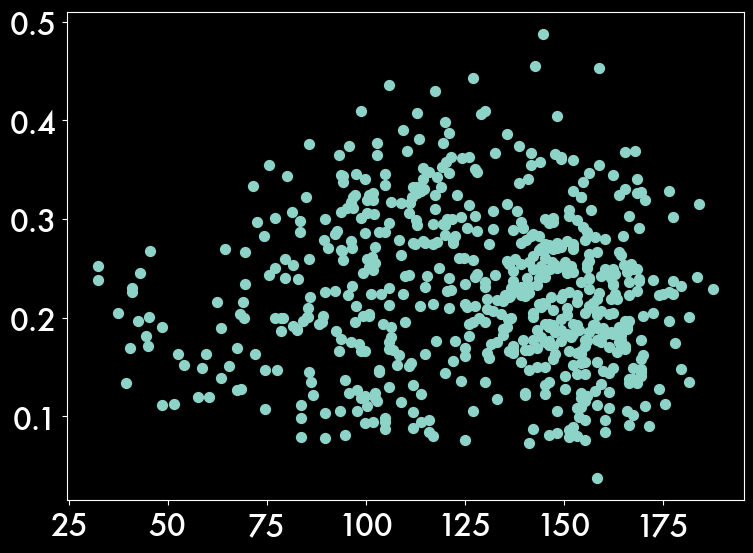

In [ ]:
fig = plt.figure(figsize=(8,6), layout='tight')
ax = fig.gca()

ax.scatter(mlpres, nitrate_variance, s=50) #, vmin=1.5, vmax=3.6) #, marker='s')

(200.0, 0.0)

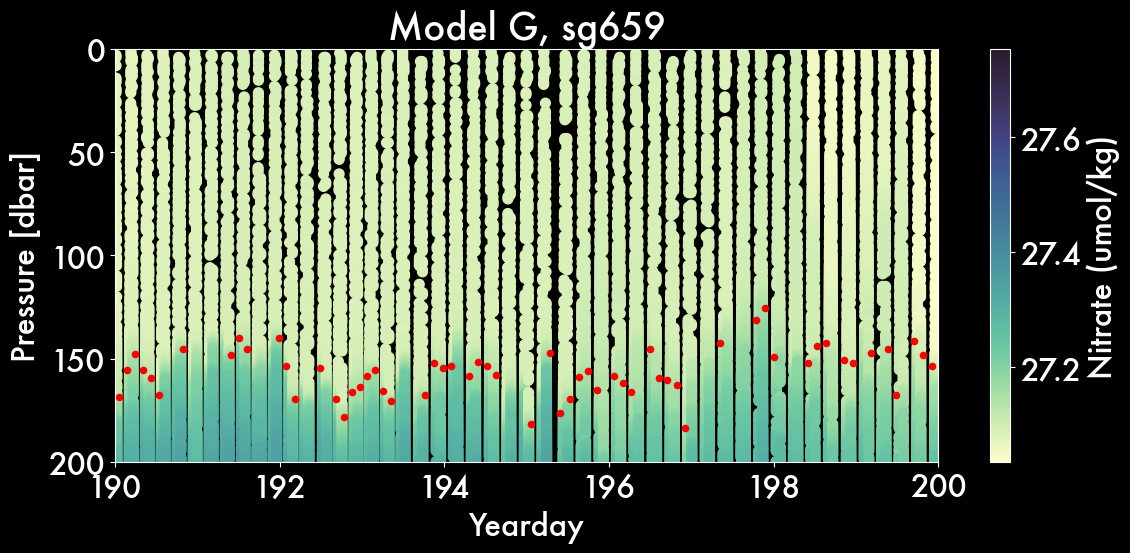

In [ ]:
# * Preidction, Obs, and Error Profiles
minday = 190
maxday = 200

dat = df_659[(df_659.yearday <maxday) & (df_659.yearday > minday)]
tag = 'Model G, sg659'


fig  = plt.figure(figsize=(12,6), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.sigma0, cmap=cmo.deep, s=50) #, vmin=1.5, vmax=3.6) #, marker='s')
ax.set_title(tag )

ax.scatter(dav_659.yearday, dav_659.mld, color='r', s=20)

plt.colorbar(sca, ax=ax).set_label('Nitrate (umol/kg)')

ax.invert_yaxis()
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')
ax.set_xlim([minday, maxday])
ax.set_ylim([200,0])



In [ ]:
dav_659.to_csv('../working-vars/glider/mld_659_1101.csv')
dav_660.to_csv('../working-vars/glider/mld_660_1101.csv')